<div style="display: flex; align-items: center; justify-content: flex-start; text-align: left; width: fit-content; margin: 0 auto;">
    <img src="https://media.giphy.com/media/LO8oXHPum0xworIyk4/giphy.gif?cid=ecf05e47mbgvh6ylsgvcjv4motlmhj5eqzukcs5tg9kltdn3&ep=v1_gifs_search&rid=giphy.gif&ct=g"
         style="max-width: 30px; margin-right: 10px;">
    <span>Starting from 7th notebook versions I use recalculated SII scores (see explanations below).</span>
</div>

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from pathlib import Path

In [365]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# Understanding the task

The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features.

sii is derived from `PCIAT-PCIAT_Total`, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

Target Variable (sii) is defined as:
- 0: None (PCIAT-PCIAT_Total from 0 to 30)
- 1: Mild (PCIAT-PCIAT_Total from 31 to 49)
- 2: Moderate (PCIAT-PCIAT_Total from 50 to 79)
- 3: Severe (PCIAT-PCIAT_Total 80 and more)

This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Type of Machine Learning Problem we can use with sii as a target:

1. Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)
2. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
3. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)
4. Custom (e.g. loss functions that penalize errors based on the distance between categories)

We can also use `PCIAT-PCIAT_Total` as a continuous target variable, and implement regression on `PCIAT-PCIAT_Total` and then map predictions to sii categories.

Finally, another strategy involves predicting responses to each question of the Parent-Child Internet Addiction Test: i.e. pedict individual question scores as separate targets, sum the predicted scores to get the `PCIAT-PCIAT_Total` and map predictions to the corresponding sii category.


But first, let's make some exploratory data analysis.

# Data Preview

In [366]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_dict = pd.read_csv('data_dictionary.csv')

### Train data

In [367]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


### Test data

In [368]:
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


### Data dictionary

In [369]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


Helper functions

In [370]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">Target Variables and Internet use</p>

Let's identify the features that are related to the target variable and that are not present in the test set.

In [371]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


**Parent-Child Internet Addiction Test (PCIAT):** contains 20 items (`PCIAT-PCIAT_01` to `PCIAT-PCIAT_20`), each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction.

We also have season of participation in `PCIAT-Season` and total Score in `PCIAT-PCIAT_Total`; so there are 22 PCIAT test-related columns in total.

Let's verify that the `PCIAT-PCIAT_Total` align with the corresponding sii categories by calculating its minimum and maximum scores for each sii category:

In [372]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [373]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

### Check missing answers

<div style="display: flex; justify-content: flex-start; align-items: flex-start; text-align: left;">
    <img src="https://media.giphy.com/media/LO8oXHPum0xworIyk4/giphy.gif?cid=ecf05e47mbgvh6ylsgvcjv4motlmhj5eqzukcs5tg9kltdn3&ep=v1_gifs_search&rid=giphy.gif&ct=g" style="max-width: 3%; margin-right: 10px;">
    <span style="display: inline-block;">Thanks to a nice catch by Broccoli Beef (<a href="https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/536407#3000620">here</a>) we also know that some of the Parent-Child Internet Addiction Test questions can be ignored by a respondent (missing values in the PCIAT-PCIAT_01 to PCIAT-PCIAT_20 columns), but the SII score is still derived from the the sum of the non-NA values, leading to potentially invalid SII values (unless, of course, some answers were cut out after the data has been collected, just to give us a bit more of a challenge.)</span>
</div>

In [374]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


For example, in the 1st and 3rd rows you can see that the score for one answer is missing. And since each question is scored from 1 to 5, the total score could be up to 5 points higher and correspond to the next SII category (SII can be 0 or 1 for the first row and 1 or 2 for the third). For the second row, `PCIAT-PCIAT_Total` and `sii` appears to have been filled in by mistake, as there are no test questions answered at all.

Let's check if PCIAT-PCIAT_Total was indeed calculated as a sum of non-NA values in  `PCIAT-PCIAT_01` to `PCIAT-PCIAT_20` columns:

In [375]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

np.True_

For now, we can conclude that the SII score is sometimes incorrect. Below I recalculate the SII based on `PCIAT_Total` and the maximum possible score if missing values were answered (5 points), ensuring that the recalculated SII meets the intended thresholds even with some missing answers.

In [376]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

Verification of rows with different original and recalculated SII:

In [377]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note: Well, for 17 rows the target variable was calculated incorrectly (ignoring missing responses).
</div>

<div style="border: 2px solid #c9c9c9; padding: 15px; border-radius: 5px; background-color: #f7f7f7;">
    <h3>Explanation of what I've just done:</h3>
    If unanswered questions are automatically counted as zeros, this can introduce an error!<br><br>
    Please, look at the last row of the table above. This respondent answered 18 out of 20 questions for a total score (PCIAT-PCIAT_Total) of 42. The initial SII is 1 because a score of 31-49 is equivalent to SII 1, 'Mild'. BUT we don't know how this person would have answered the missing questions - they could have scored 0, 5 or something in between. To account for this, I add the maximum possible score (5) for each unanswered question, giving a max_possible score of 52, which is in the 'Moderate' SII range (SII = 2 if PCIAT-PCIAT_Total is between 50 and 79). The initial SII = 1, may be wrong or right - we do not know! So recalculating SII with my `recalculate_sii` function will result in SII = NaN, not SII = 2 or something else.<br><br>
    This approach ensures that all ambiguous SII scores (those potentially affected by unanswered questions) are marked as NaN.<br><br>
</div>

In the following analyses I'll only use the corrected SII. I will only use total scores if all PCIAT_cols have non-NA values (all questions of the Parent-Child Internet Addiction Test have been answered).

In [378]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

### Plot distribution of the target variable

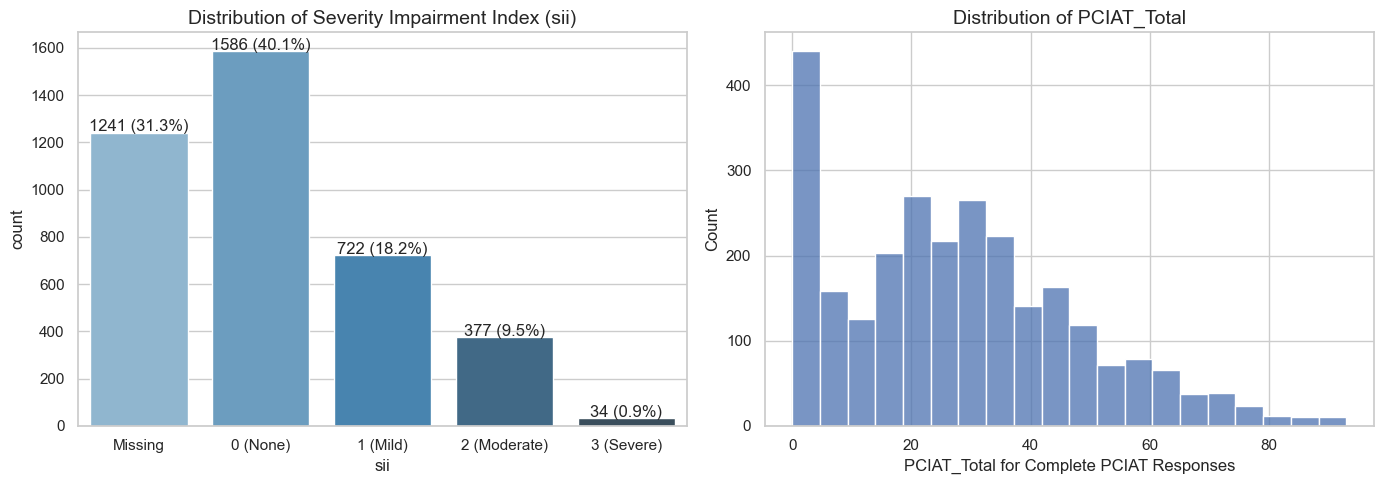

In [379]:
sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

In [380]:
len(train[train['complete_resp_total'] == 0])

307

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note: Apparently, 40% of the participants were not affected by Internet use, 31% were not assessed, and only the minority (~10%) are moderately to severely impaired. There are 307 participants who scored 0 on all PCIAT questions.
</div>

### SII by age and sex

In [381]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

In [382]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [383]:
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,2484 (62.73%)
Female,1476 (37.27%)


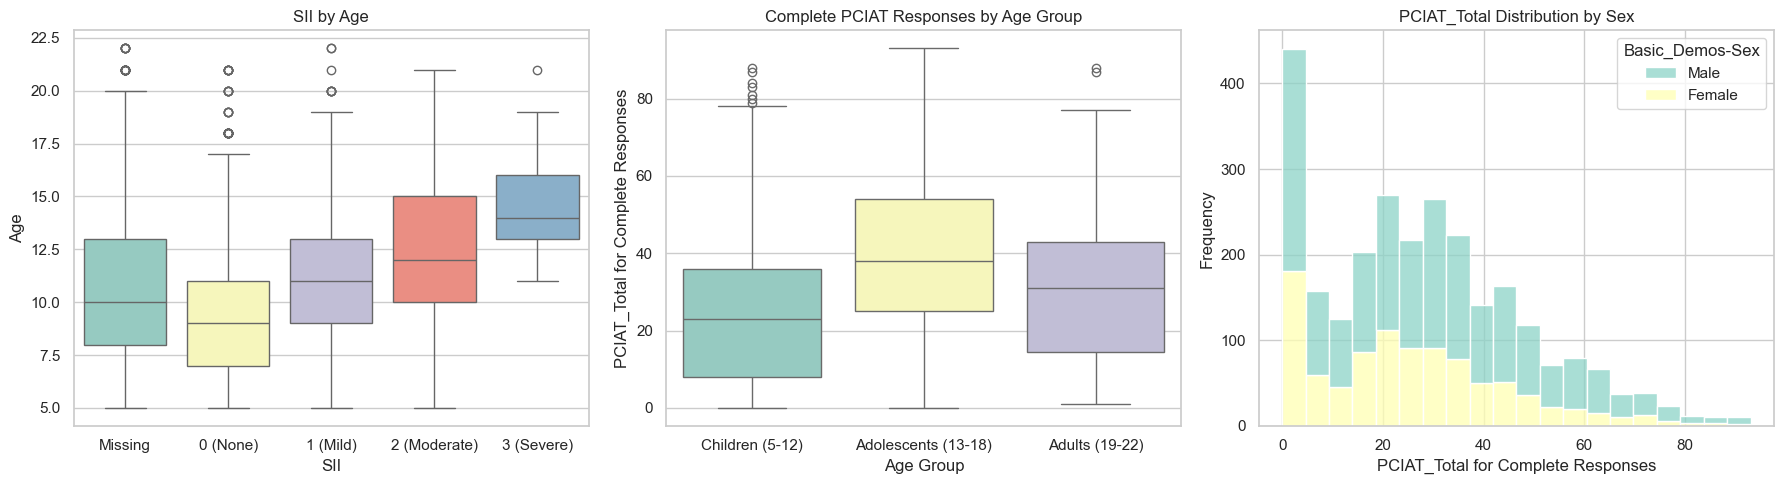

In [384]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

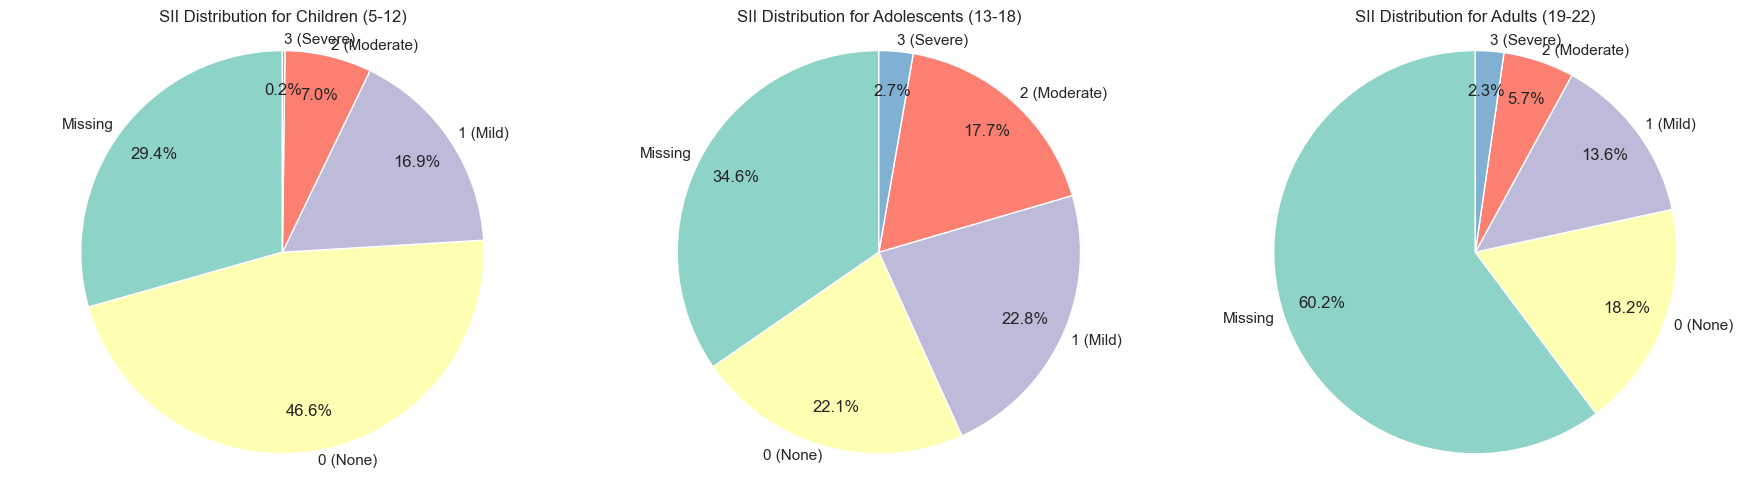

In [385]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

The distribution of sii across different age groups:

In [386]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),858 (29.4%),1359 (46.6%),493 (16.9%),203 (7.0%),6 (0.2%)
Adolescents (13-18),330 (34.6%),211 (22.1%),217 (22.8%),169 (17.7%),26 (2.7%)
Adults (19-22),53 (60.2%),16 (18.2%),12 (13.6%),5 (5.7%),2 (2.3%)


Calculate percentages for participants with non-missing SII only:

In [387]:
stats = train[train['sii'] != 'Missing'].groupby(
    ['Age Group', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),0 (0.0%),1359 (65.9%),493 (23.9%),203 (9.8%),6 (0.3%)
Adolescents (13-18),0 (0.0%),211 (33.9%),217 (34.8%),169 (27.1%),26 (4.2%)
Adults (19-22),0 (0.0%),16 (45.7%),12 (34.3%),5 (14.3%),2 (5.7%)


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The box plots are different representations of the target variable in it's categorised (SII) and numerical (PCIAT_Total) form. They show that higher SII scores are generally associated with older age groups, but there's considerable overlap in the age ranges within each category, and the median PCIAT_Total is higher in adolescents, suggesting a U-shaped relationship between age and PIU impairment (the peak of Internet-related problems may occur during adolescence).
<li>Accordingly, in the pie charts, the distribution of SII for children and adults is skewed towards lower values (none and mild), whereas, for adolescents, the distribution is more balanced across the categories of none, mild and moderate.
<li>But what about the numbers (see tables)? The number of adolescents is much lower than that of children, and the number of adult participants is extremely low (88 in total and only 36 with SII)!
<li>As we have seen from the graphs in the previous section, the overall distribution of SII is skewed towards lower values and severe cases are rare. So there may be relationships that we cannot see with such unequal sample sizes and under-representation of severe cases.
<li>The differences between males and females are relatively subtle.
    </ul>
</div>

# Internet Use

Internet usage data is crucial to this task because Problematic internet use (PIU), also known as internet addiction or compulsive internet use, refers to excessive and unhealthy use of the internet that interferes with a person’s daily life, responsibilities, and social relationships. The internet usage data provides a direct measure of how much time each participant spends online.

In [388]:
data = train[train['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data: 5 - 22 years


In [389]:
train['PreInt_EduHx-computerinternet_hoursday'].unique()

array([ 3.,  0.,  2., nan,  1.])

In [390]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [391]:
calculate_stats(train, 'PreInt_EduHx-Season')

,count (%)
PreInt_EduHx-Season,
Fall,828 (20.91%)
Summer,821 (20.73%)
Winter,906 (22.88%)
NaN,420 (10.61%)
Spring,985 (24.87%)


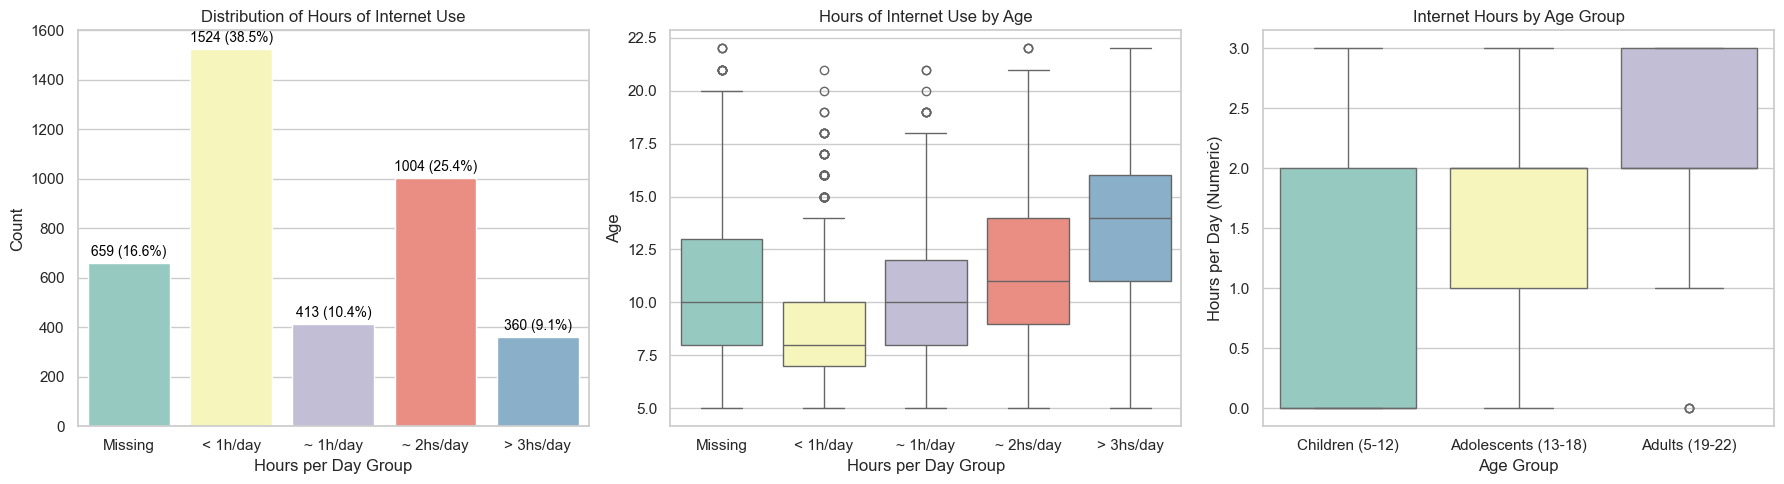

In [392]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hours of Internet Use
ax1 = sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=axes[0])
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Hours of Internet Use by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], ax=axes[1], palette="Set3")
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# Hours of Internet Use (numeric) by Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, ax=axes[2], palette="Set3")
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

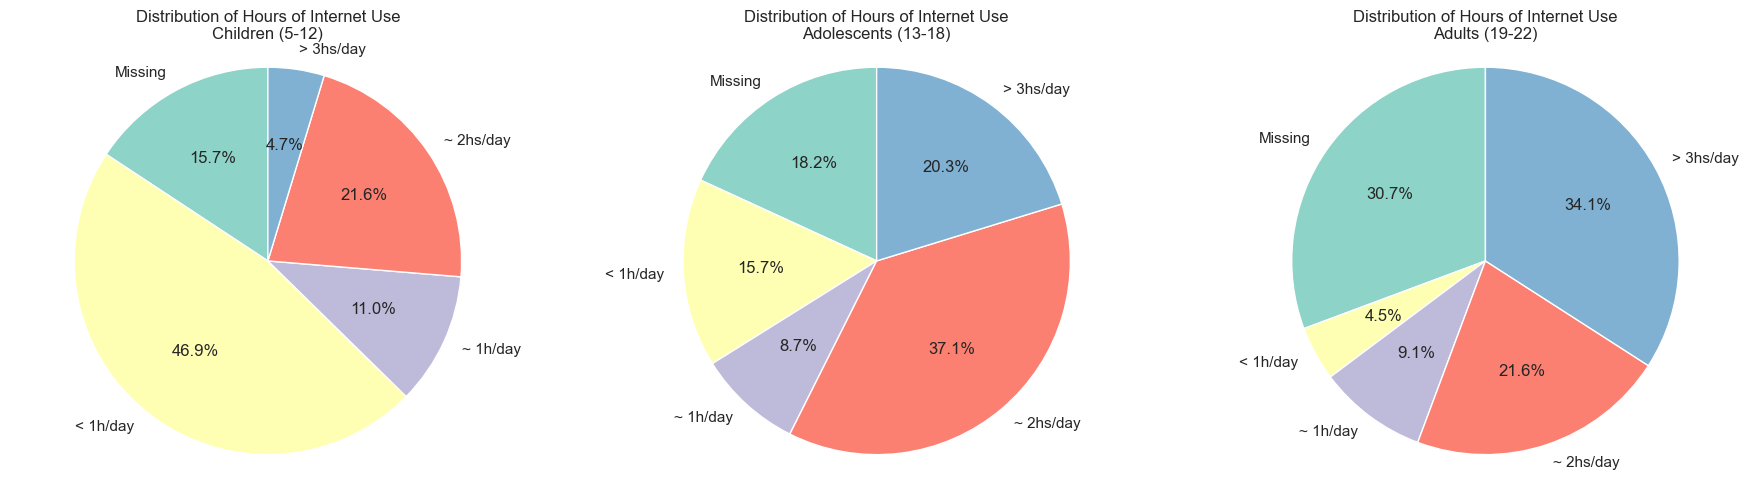

In [393]:
stats = train.groupby(
    ['Age Group', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1)
    axes[i].set_title(f'Distribution of Hours of Internet Use\n{age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [394]:
train_non_na = train.dropna(subset=['PreInt_EduHx-computerinternet_hoursday'])
rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 3).sum()
print(f"Non-NA Rows - Internet use 3h or more: {(rows / len(train_non_na)) * 100:.2f}%")

rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 0).sum()
print(f"Non-NA Rows - Internet use 1h or less: {(rows / len(train_non_na)) * 100:.2f}%")

Non-NA Rows - Internet use 3h or more: 10.91%
Non-NA Rows - Internet use 1h or less: 46.17%


In [395]:
stats = train.groupby(['Basic_Demos-Sex', 'internet_use_encoded']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

internet_use_encoded,Missing,< 1h/day,~ 1h/day,~ 2hs/day,> 3hs/day
Basic_Demos-Sex,,,,,
Female,271 (18.4%),569 (38.6%),139 (9.4%),353 (23.9%),144 (9.8%)
Male,388 (15.6%),955 (38.4%),274 (11.0%),651 (26.2%),216 (8.7%)


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>Internet usage data is missing for 16.6% of participants, while 38.5% reported using the Internet less than hour a day.
<li>Similar to the SII data, the box plots reveals that higher daily internet usage is associated with older age, with considerable overlap in age ranges within each internet usage category. But here both the categorical and numeric representations of hours spent online indicate a consistent linear relationship.
<li>The pie charts for age groups are well aligned and shows the same.
<li>Creating an interaction feature between internet use and age could potentially be useful for modeling.
<li>Internet use is fairly similar for both sexes.
    </ul>
</div>

### Internet usage vs SII (target)

Competition description states that the goal is: to detect early indicators of problematic Internet and technology use (PIU), while the definition of PUI includes excessive use of internet:

> PUI is an umbrella term that encompasses a set of potentially harmful online behaviors that are repetitive and uncontrolled, to the point that they are prioritized over other life interests and persist despite negative consequences.

*[Fendel, J. C., Vogt, A., Brandtner, A., & Schmidt, S. (2024). Mindfulness programs for problematic usage of the internet: A systematic review and meta-analysis. Journal of behavioral addictions, 13(2), 327–353.](https://doi.org/10.1556/2006.2024.00024)*

So let's see how much time the participants with different impairment scores (SII) spent online in this dataset.

In [396]:
sii_reported = train[train['sii'] != "Missing"]
sii_reported.loc[:, 'sii'] = sii_reported['sii'].cat.remove_unused_categories()

In [397]:
stats = sii_reported.groupby(
    ['internet_use_encoded', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
internet_use_encoded,,,,
Missing,52 (63.4%),15 (18.3%),15 (18.3%),0 (0.0%)
< 1h/day,933 (73.9%),247 (19.6%),78 (6.2%),5 (0.4%)
~ 1h/day,160 (47.2%),123 (36.3%),54 (15.9%),2 (0.6%)
~ 2hs/day,366 (47.2%),251 (32.3%),147 (18.9%),12 (1.5%)
> 3hs/day,75 (29.0%),86 (33.2%),83 (32.0%),15 (5.8%)


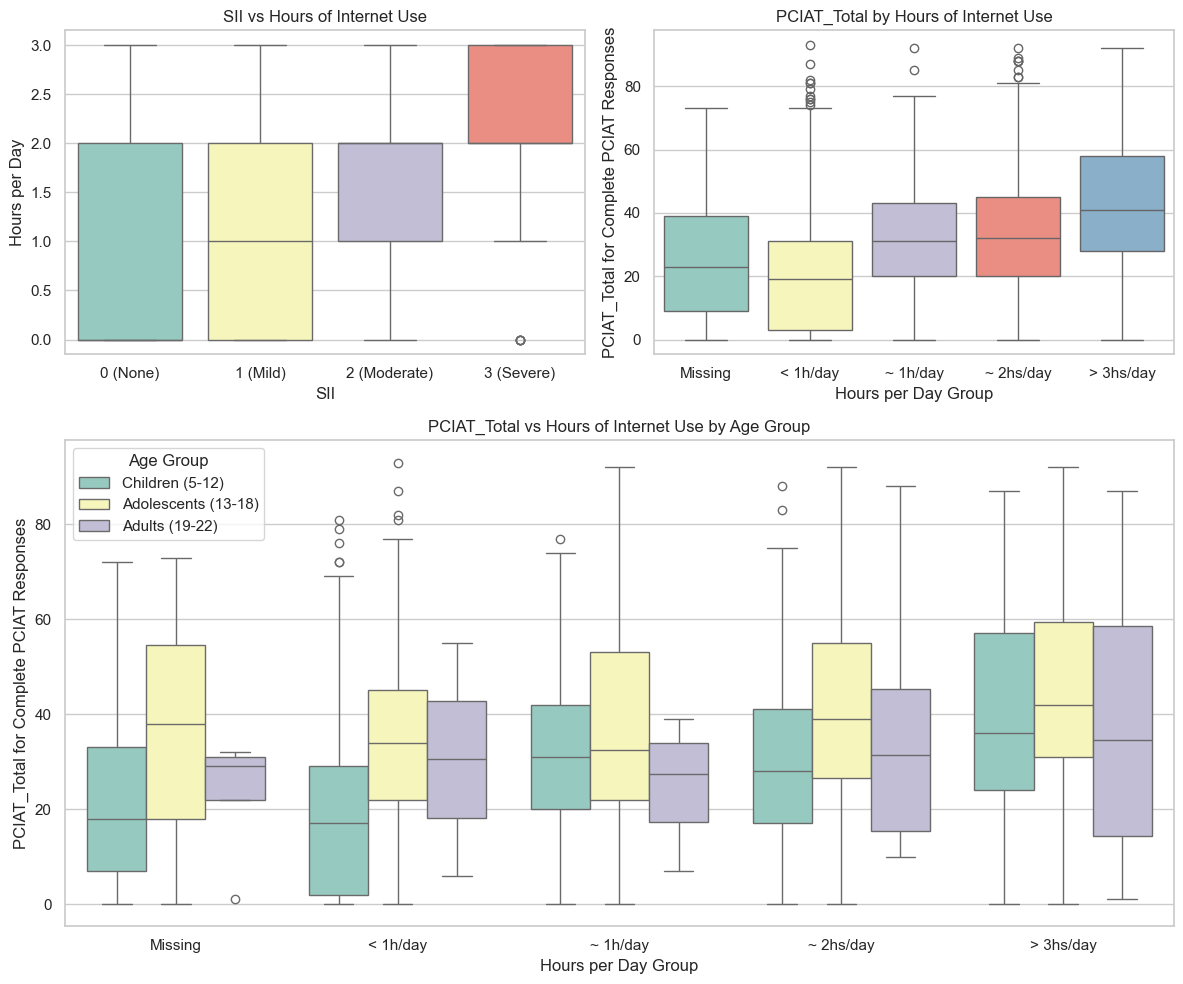

In [398]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# SII vs Hours of Internet Use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    ax=ax1, palette="Set3"
)
ax1.set_title('SII vs Hours of Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# PCIAT_Total for Complete PCIAT Responses by Hours of Internet Use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    palette="Set3", ax=ax2
)
ax2.set_title('PCIAT_Total by Hours of Internet Use')
ax2.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax2.set_xlabel('Hours per Day Group')

# SII vs Hours of Internet Use by Age Group (Full width)
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    hue='Age Group', ax=ax3, palette="Set3"
)
ax3.set_title('PCIAT_Total vs Hours of Internet Use by Age Group')
ax3.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax3.set_xlabel('Hours per Day Group')

plt.tight_layout()
plt.show()

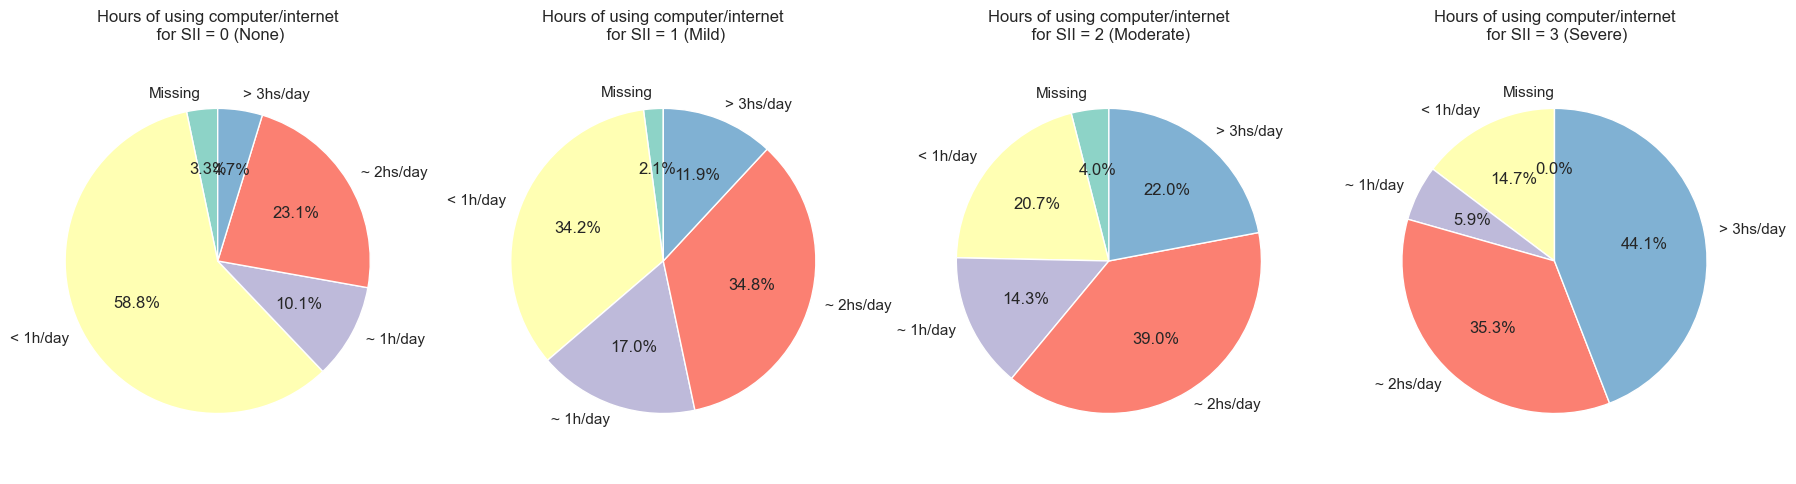

In [399]:
stats = sii_reported.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, sii_group in enumerate(stats.index):
    group_counts = stats.loc[sii_group] / stats.loc[sii_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1
    )
    axes[i].set_title(f'Hours of using computer/internet\n for SII = {sii_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [400]:
stats = sii_reported.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

internet_use_encoded,Missing,< 1h/day,~ 1h/day,~ 2hs/day,> 3hs/day
sii,,,,,
0 (None),52 (3.3%),933 (58.8%),160 (10.1%),366 (23.1%),75 (4.7%)
1 (Mild),15 (2.1%),247 (34.2%),123 (17.0%),251 (34.8%),86 (11.9%)
2 (Moderate),15 (4.0%),78 (20.7%),54 (14.3%),147 (39.0%),83 (22.0%)
3 (Severe),0 (0.0%),5 (14.7%),2 (5.9%),12 (35.3%),15 (44.1%)


In [401]:
train[
    (train['internet_use_encoded'] == '< 1h/day') &
    (train['sii'].isin(['2 (Moderate)', '3 (Severe)']))
]['Basic_Demos-Age'].describe()

count    83.000000
mean     10.626506
std       3.083041
min       5.000000
25%       8.500000
50%      10.000000
75%      12.500000
max      21.000000
Name: Basic_Demos-Age, dtype: float64

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>In the box plots, despite the considerable overlap between the different SII and internet use categories, we see a positive trend between PIU impairment and internet use, with people with higher SII scores spending more time online (it would be strange if this wasn't the case, as excessive internet use is assumed by the PIU definition).
<li>However, when the relationship between PCIAT_Total and hours of Internet use is further broken down by age group (bottom boxplot), the non-linear relationship between age, Internet use and PIU emerges, with adolescents standing out as the most affected age group across all categories of Internet use.
<li>The pie charts also show that there is a significant proportion of participants (83 in total), of all ages, who spend very little time online (less than 1 hour per day) but have high SII scores (20.7% with SII 2 - moderately impaired and 14.7% with SII = 3 - severely impaired).
    </ul>
</div>

<div style="border: 2px solid #c9c9c9; padding: 15px; border-radius: 5px; background-color: #f7f7f7;">
    <h3>Summary of Findings</h3>
    <ol>
        <li>The SII scores tend to increase with age but show a U-shaped relationship, with adolescents having the highest median PCIAT scores.</li>
        <li>The higher the age, the more hours participants spent online (clear linear trend).</li>
        <li>People with higher SII scores generally spend more time online, but adolescents stand out as the most affected age group across all categories of internet use.</li>
        <li>There are participants of almost all ages (5 to 21) who spend less than an hour a day online and have high SII scores.</li>
    </ol>
    <p><em>Note:</em> These results should be interpreted with caution, as there is considerable overlap between the different SII and internet use categories, and severe cases and adults are under-represented in the data.</p>
</div>

<div style="border: 2px solid #c9c9c9; padding: 15px; border-radius: 5px; background-color: #f7f7f7;">
    <h3>Interpretation</h3>
    <p>The relationship between SII and internet usage time is not as straightforward as one might expect, given the definition of PIU (aka internet addiction). This is because factors beyond just the hours spent online contribute to the SII, and the above analysis suggest that the age is particularly crucial: adolescents appear to have the highest SII across all levels of internet use... But how to interpret this: are they more susceptible to PIU, or is this questionnaire just more sensitive to PIU in this age group? Let's try to understand what exacly our target variable reflect.</p>
    <p>The questions in the PCIAT questionnaire (used to derive the SII, see data_dict.csv) appear to be designed to measure emotional and social impacts associated with internet use (emotional dependence on the internet, social isolation, neglect of responsibilities, and the impact of internet use on relationships and mood). In other words, the intend was to measure show how problematic the behaviour associated with internet use is. However, parents' perceptions are naturally biased and influenced by various factors - such as their own internet habits, cultural attitudes, or their wishes/ideas about how their children should behave.</p>
    <p>Furthermore, can you imagine that spending less than an hour a day online could in itself lead to problems such as emotional distress, neglect of duties or withdrawal from family? I don't think an hour a day of any content on the internet can lead to any of those things... The presence of this in the data only proves that respondents are not being honest in answering the PCIAT questions and internet use, or that SII scores are being influenced by other factors that have nothing to do with the PIU.</p>
    <p>The former point out that the single feature that links all the other data we have (physical activity, accelerometer data, sleep, etc.) to internet use (and we need this connection to predict the impact of PIU) may be unreliable and biased as well as the target variable.</p>
    <p>The latter imply that participants may have various pre-existing social behaviours or moods that are unrelated to Internet use (and PIU) per se. The questionnaire is a subjective tool, even when completed by parents, while adolescence is an outstanding period in life - a time of identity formation, evolving peer relationships, and a search for independence - all of which can amplify behaviors like mood swings, disobedience, and impulsivity. Consequently, the SII may be capturing how problematic are these broader developmental behaviors rather than internet use specifically.</p>
    <p>Additionally, the applicability of the questionnaire across the age range is questionable. I think all the questions in the PCIAT are much more suitable for adolescents. For example:</p>
        <ul style="list-style:circle">
            <li>A 5-7-year-old may not have household chores, as this depends on cultural norms.
            <li>The question about academic impact may not apply to younger children who are not yet in school or graduated adults.
            <li>Email use and receiving phone calls from "online friends" seem out of context for young children too.
            <li>Questions about reaction to the time allowed to spend on the internet (there are at least 3 of them) are not applicable to adults... usually.
        </ul>
    <p>Questions not applicable to a participant’s age could lead to skewed or irrelevant responses. All of these challenges the construct validity of SII and considers whether it accurately measures PIU or is affected by other behavioral factors.</p>
</div>

<div style="width: 100%; display: flex; justify-content: space-between;
            align-items: center; padding: 10px 0; background-color: #fff;">
    <img src="https://img.icons8.com/?size=100&id=FDI4JxAMODWm&format=png&color=000000"
         alt="Flower" style="margin: 0 10px;">
   <img src="https://img.icons8.com/?size=100&id=33505&format=png&color=000000"
         alt="Flower" style="margin: 0 10px;">
     <img src="https://img.icons8.com/?size=100&id=zNMWGK0lHFdq&format=png&color=000000"
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=swcZVLFGWY9T&format=png&color=000000"
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
     <img src="https://img.icons8.com/?size=100&id=71328&format=png&color=000000"
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=16971&format=png&color=000000"
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=0Jf0JX4aVU0x&format=png&color=000000"
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
</div>

# Features EDA by Groups

Here’s how we can classify types of the features in this dataset:

- Categorical: Variables with discrete categories but no inherent order (represented as strings, e.g., season of enrollment)
- Encoded categorical features (already encoded as integers, e.g. sex)
- Continuous: Variables that can take any value within a range (e.g., age, enmo, heart_rate).
- Ordinal: Variables with a defined order but not necessarily equidistant categories (e.g., questionnaire responses).

And here are different features groups:

In [402]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

### Season-related columns

The presence of different season-related columns likely reflects the timing of data collection or participation in the study. Seasonal changes may play a significant role in the variables being measured (e.g., fitness, physical activity, sleep patterns, and of course internet usage).

In [403]:
season_columns = [col for col in train.columns if 'Season' in col]
season_df = train[season_columns]
season_df

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
0,Fall,Winter,Fall,NaN,Fall,Fall,NaN,NaN,Fall,NaN,Fall
1,Summer,NaN,Fall,NaN,Fall,Winter,NaN,Fall,Fall,Fall,Summer
2,Summer,Fall,Fall,Fall,Fall,NaN,NaN,Summer,Fall,Fall,Summer
3,Winter,Fall,Summer,Summer,Summer,Summer,NaN,Winter,Summer,Summer,Winter
4,Spring,Summer,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,Spring,Fall,NaN,Fall,Fall,NaN,Winter,Winter,Winter,Fall
3956,Winter,NaN,Spring,NaN,Spring,Spring,NaN,Winter,NaN,NaN,Winter
3957,Fall,Spring,Winter,NaN,Winter,Winter,NaN,Winter,Winter,Winter,Fall
3958,Spring,Spring,Winter,NaN,Spring,Summer,NaN,Spring,Spring,Spring,Spring


In [404]:
train[season_columns] = train[season_columns].fillna("Missing")

### Grouping of features by type and measurement method
Having examined the contents of data_dict in detail, I believe that the characteristics can also be grouped according to their type and method of measurement (the diagram was made with [napkin](https://app.napkin.ai/)):


![napkin-selection (2).png](attachment:c359295e-1571-4287-a3f9-a30da49114bd.png)

### Potential connection to problematic internet use (PIU)
- Behavioral (subjective reported):
  - A person can't have PIU if they don't use the internet, so I would expect `PreInt_EduHx-computerinternet_hoursday` to be the most important feature, but as we saw above, its relationship with the target can be non-linear.
  - Behavioural tendencies associated with PIU may be reflected in the physical activity score derived from the questionnaires (`PAQ_A-PAQ_A_Total` and `PAQ_C-PAQ_C_Total`).   
  
  However, both features are self-reports and are likely to be biased and inaccurate, so I would expect noise here.
  
- Physical Health and Fitness (objective measurements):
  - The Children's Global Assessment Scale (`CGAS-CGAS_Score`) is a clinician-rated score reflecting general functioning. For individuals with PIU, this score can indicate how PIU impacts overall functioning.
  - Physical health measures include body composition and vital signs (feature columns starting with `Physical-`), and may reflect how problematic internet use is in terms of its impact on general health (note that height alone may not be as relevant, but combined with weight it gives BMI - a measure of body fat).
  - Bio-electric Impedance Analysis assess body composition and metabolic health (body fat, muscle mass, water content, metabolic rate, etc.), PIU, if assosiated with sedentary behavior could be reflected through changes in these variables (lower bone density, lower lean muscle mass, reduced daily energy expenditure, poor hydration, decrease in fat-free mass, higher body fat percentages, and so on).
  - Objective measures of physical activity include FitnessGram results (endurance, curl, grip, push-up, sit & reach, trunk lift - feature columns starting with `Fitness_` and `FGC-FGC_`). These can indicate how problematic internet use is in terms of its impact on muscle strength and tonus.
  - An assessment of sleep-related issues (feature columns `SDS-SDS_Total_Raw`, `SDS-SDS_Total_T`) could reflect the extent to which PIU disrupts sleep patterns.
- Demographic features:
  - Age and gender can be extremely important, as there may be gender and especially age-specific patterns (as we have already seen above) associated with Internet use and PIU)

Remove target-related columns and continue EDA by feature groups.

In [405]:
data_dict = data_dict[data_dict['Instrument'] != 'Parent-Child Internet Addiction Test']
continuous_cols = data_dict[data_dict['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()

# target = train[['sii']]
# train = train.drop(columns = columns_not_in_test)

# <p style="background-color:#FFFFE0; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #FFD700; border-radius:15px; padding:20px 20px;">- Demographics</p>

In [406]:
groups.get('Demographics', [])

['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

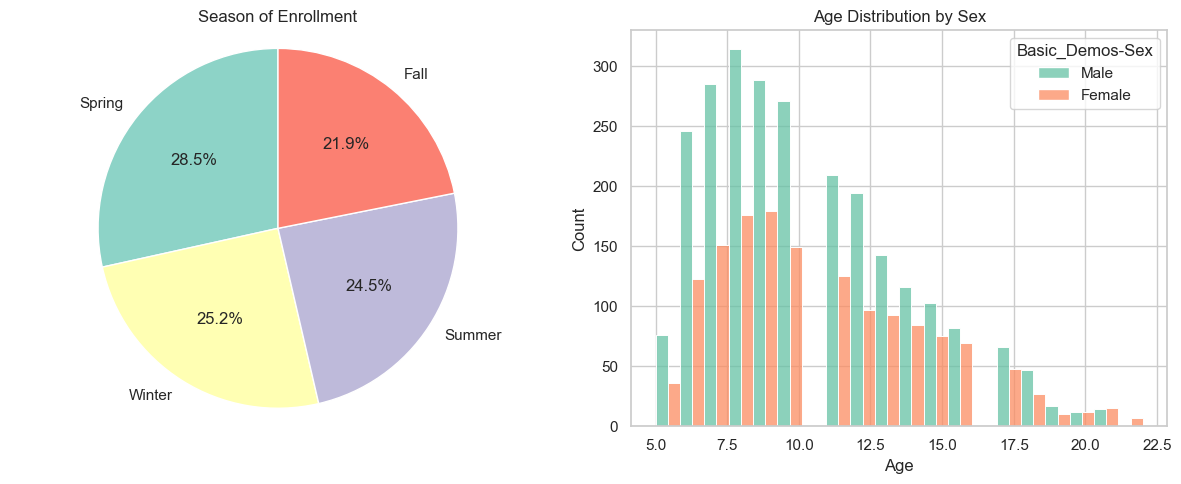

In [407]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Season of Enrollment
season_counts = train['Basic_Demos-Enroll_Season'].value_counts(dropna=False)

axes[0].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[0].set_title('Season of Enrollment')
axes[0].axis('equal')

# Age Distribution by Sex
sns.histplot(
    data=train, x='Basic_Demos-Age',
    hue='Basic_Demos-Sex', multiple='dodge',
    palette="Set2", bins=20, ax=axes[1]
)
axes[1].set_title('Age Distribution by Sex')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

0=Male, 1=Female

In [408]:
calculate_stats(train, 'Basic_Demos-Age')

,count,mean,std,min,25%,50%,75%,max,missing
Basic_Demos-Age,,,,,,,,,
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.0,10.0,13.0,22.0,0


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The distribution of enrollment by season is relatively balanced, with the highest enrollment in Spring (28.5%) and the lowest in Fall (21.9%).
<li>There is a higher number of males (0) across most age groups, with fewer females (1) particularly visible in younger age groups.
<li>The relationships with the target variable are shown in the section  'SII by age and sex' (no difference in SII between men and women, U-shaped relationship between age and PIU impairment).
    </ul>
</div>

# <p style="background-color:#dff5e9; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #57c98a; border-radius:15px; padding:20px 20px;">Physical Health and Fitness (objective measurements)</p>

# - Children's Global Assessment Scale

In [409]:
groups.get("Children's Global Assessment Scale", [])

['CGAS-Season', 'CGAS-CGAS_Score']

In [410]:
data = train[train['CGAS-CGAS_Score'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with CGAS-CGAS_Score data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with CGAS-CGAS_Score data: 5 - 22 years


In [411]:
calculate_stats(train, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.0,65.0,75.0,999.0,1539


In [412]:
train[train['CGAS-CGAS_Score'] > 100]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,complete_resp_total,Age Group,internet_use_encoded
2065,83525bbe,Fall,11,Female,Winter,999.0,Fall,NaN,NaN,NaN,...,NaN,Missing,NaN,NaN,Fall,3.0,Missing,NaN,Children (5-12),> 3hs/day


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>There is one extreme value outlier (CGAS-CGAS_Score = 999), which is obviously an error.
    </ul>
</div>

In [413]:
train.loc[train['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan

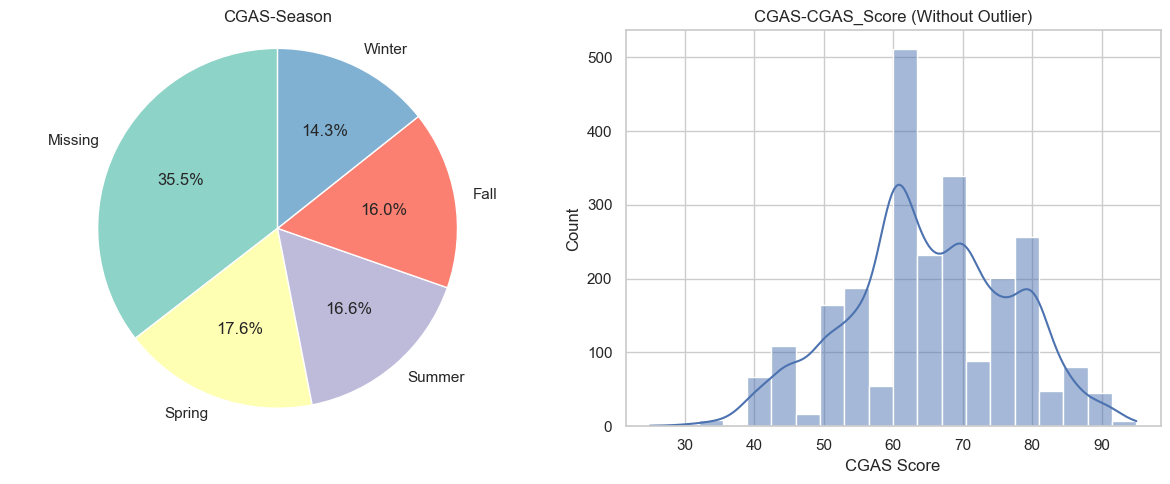

In [414]:
plt.figure(figsize=(12, 5))

# CGAS-Season
plt.subplot(1, 2, 1)
cgas_season_counts = train['CGAS-Season'].value_counts(normalize=True)
plt.pie(
    cgas_season_counts,
    labels=cgas_season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('CGAS-Season')
plt.axis('equal')

# CGAS-CGAS_Score without outliers (score == 999)
plt.subplot(1, 2, 2)
sns.histplot(
    train['CGAS-CGAS_Score'].dropna(),
    bins=20, kde=True
)
plt.title('CGAS-CGAS_Score (Without Outlier)')
plt.xlabel('CGAS Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Stats without outlier:

In [415]:
calculate_stats(train, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2420.0,65.069008,11.78731,25.0,59.0,65.0,75.0,95.0,1540


### CGAS Interpretation ([Reference](https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/))

CGAS is a rating of general functioning for children and young people aged 4-16 years old. The CGAS asks the clinician to rate the child from 1 to 100 based on their lowest level of functioning, regardless of treatment or prognosis, over a specified time period.

Since the CGAS is a measure of general functioning, and the SII reflects the severity of the impact of Internet use on that functioning, I expect this feature, along with Internet use, to be the most important in predicting the SII.

Let's bin the `CGAS-CGAS_Score` column based on the established score categories and draw counts:

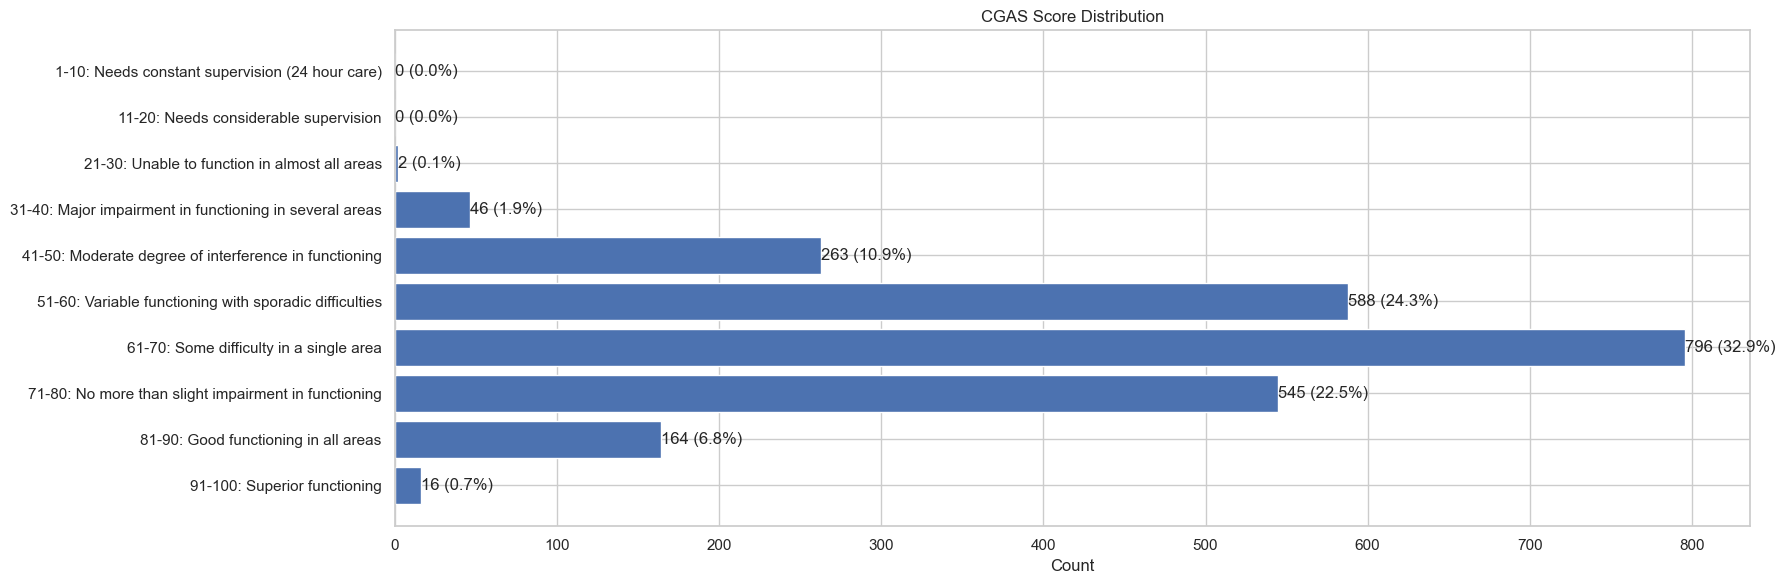

In [416]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')

for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The majority of individuals have CGAS scores between 51-80 (79.7%), i.e. sporadic difficulties to only slight impairments
<li>Two participants have extreme difficulty in functioning
    </ul>
</div>

Examine relationships with the target variable:

In [417]:
train_filt = train.dropna(subset=['CGAS_Score_Bin', 'complete_resp_total'])
train_filt.loc[:, 'CGAS_Score_Bin'] = train_filt['CGAS_Score_Bin'].cat.remove_unused_categories()
train_filt.loc[:, 'sii'] = train_filt['sii'].cat.remove_unused_categories()
len(train_filt)

2288

C:\Users\Admin\AppData\Local\Temp\ipykernel_49648\2813081828.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(range_labels)


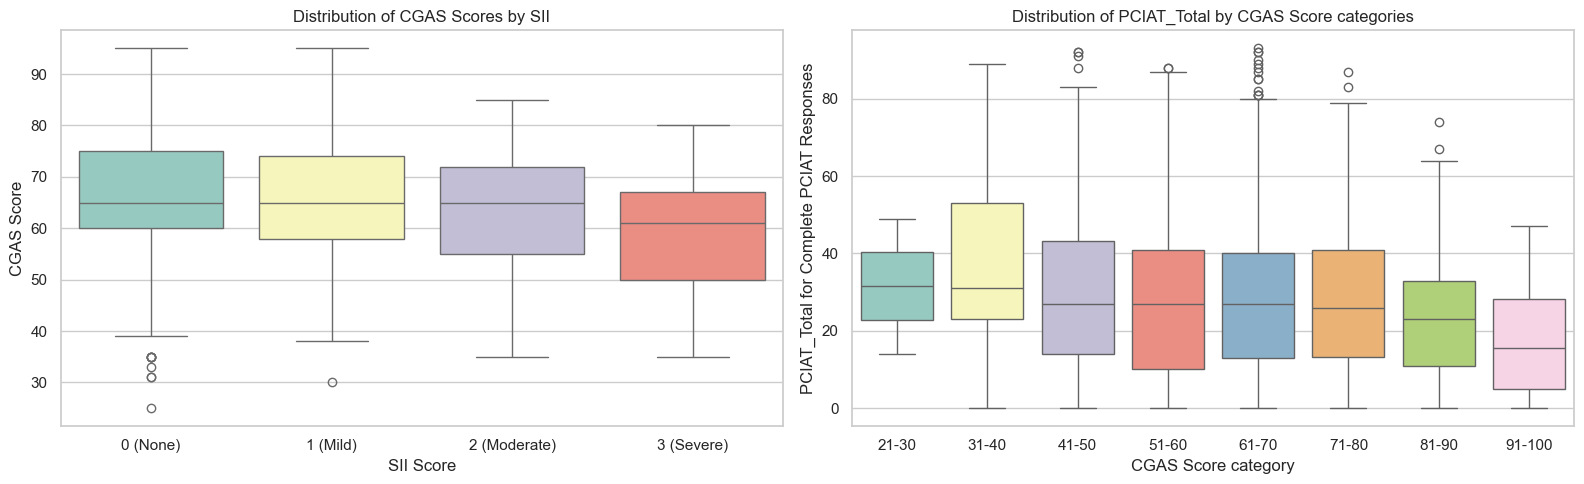

In [418]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CGAS-CGAS_Score vs sii
sns.boxplot(
    data=train_filt,
    x='sii', y='CGAS-CGAS_Score',
    palette='Set3', ax=axes[0]
)
axes[0].set_xlabel('SII Score')
axes[0].set_ylabel('CGAS Score')
axes[0].set_title('Distribution of CGAS Scores by SII')

# complete_resp_total vs CGAS_Score_Bin
sns.boxplot(
    data=train_filt,
    x='CGAS_Score_Bin', y='complete_resp_total',
    ax=axes[1], palette='Set3'
)

# Get the tick positions and match the labels
range_labels = [label.split(":")[0] for label in train_filt['CGAS_Score_Bin'].cat.categories]
axes[1].set_xticklabels(range_labels)

axes[1].set_xlabel('CGAS Score category')
axes[1].set_ylabel('PCIAT_Total for Complete PCIAT Responses')
axes[1].set_title('Distribution of PCIAT_Total by CGAS Score categories')

plt.tight_layout()
plt.show()

In [419]:
score_min_max = train.groupby('sii')['CGAS-CGAS_Score'].agg(['min', 'max'])
score_min_max = score_min_max.rename(
    columns={'min': 'Minimum CGAS Score', 'max': 'Maximum CGAS Score'}
)
score_min_max

,Minimum CGAS Score,Maximum CGAS Score
sii,,
Missing,40.0,85.0
0 (None),25.0,95.0
1 (Mild),30.0,95.0
2 (Moderate),35.0,85.0
3 (Severe),35.0,80.0


Let's check the SII and Internet usage data for the participants with the worst global functioning:

In [420]:
train_filt[train_filt['CGAS-CGAS_Score'] < 35][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
2417,9,Female,0 (None),31.0,0.0
2525,13,Female,1 (Mild),30.0,0.0
2555,15,Male,0 (None),33.0,2.0
3332,12,Male,0 (None),25.0,2.0
3858,15,Male,0 (None),31.0,3.0


And the same for the participants with the best global functioning:

In [421]:
train[train['CGAS-CGAS_Score'] > 90][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
310,13,Female,0 (None),91.0,2.0
591,10,Female,0 (None),93.0,NaN
667,13,Male,0 (None),95.0,0.0
910,10,Female,0 (None),91.0,0.0
1007,14,Male,1 (Mild),95.0,0.0
1157,14,Female,1 (Mild),91.0,2.0
1640,11,Female,0 (None),92.0,0.0
2342,6,Female,0 (None),91.0,0.0
2668,14,Female,0 (None),92.0,0.0
2675,11,Male,0 (None),91.0,0.0


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>I would expect the higher the SII, the lower the median CGAS score, but the decrease is very small here.
<li>However, there are no participants with the highest SII scores (3 or severely problematic internet use) who have good CGAS scores (81-100: good/superior functioning in all domains). This suggests that parental responses to the PCIAT questionnaire (our target variable) may reflect some effects of PIU on global health and functioning.
<li>The participants with the worst and best CGAS scores all have SII 0 or 1 (no or mild PIU severity) and report varying internet use (less than 1 hours/day to 3 or more hours/day). This means in the train data there are participants with significant health issues not related to PIU.
<li>The high variability makes it hard to draw a clear, consistent conclusion about the relationship between CGAS and SII scores.
<li>Small sample sizes in certain CGAS categories make it difficult to generalize findings and may lead to biased interpretations.
    </ul>
</div>

# - Physical Measures

In [422]:
groups.get('Physical Measures', [])

['Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP']

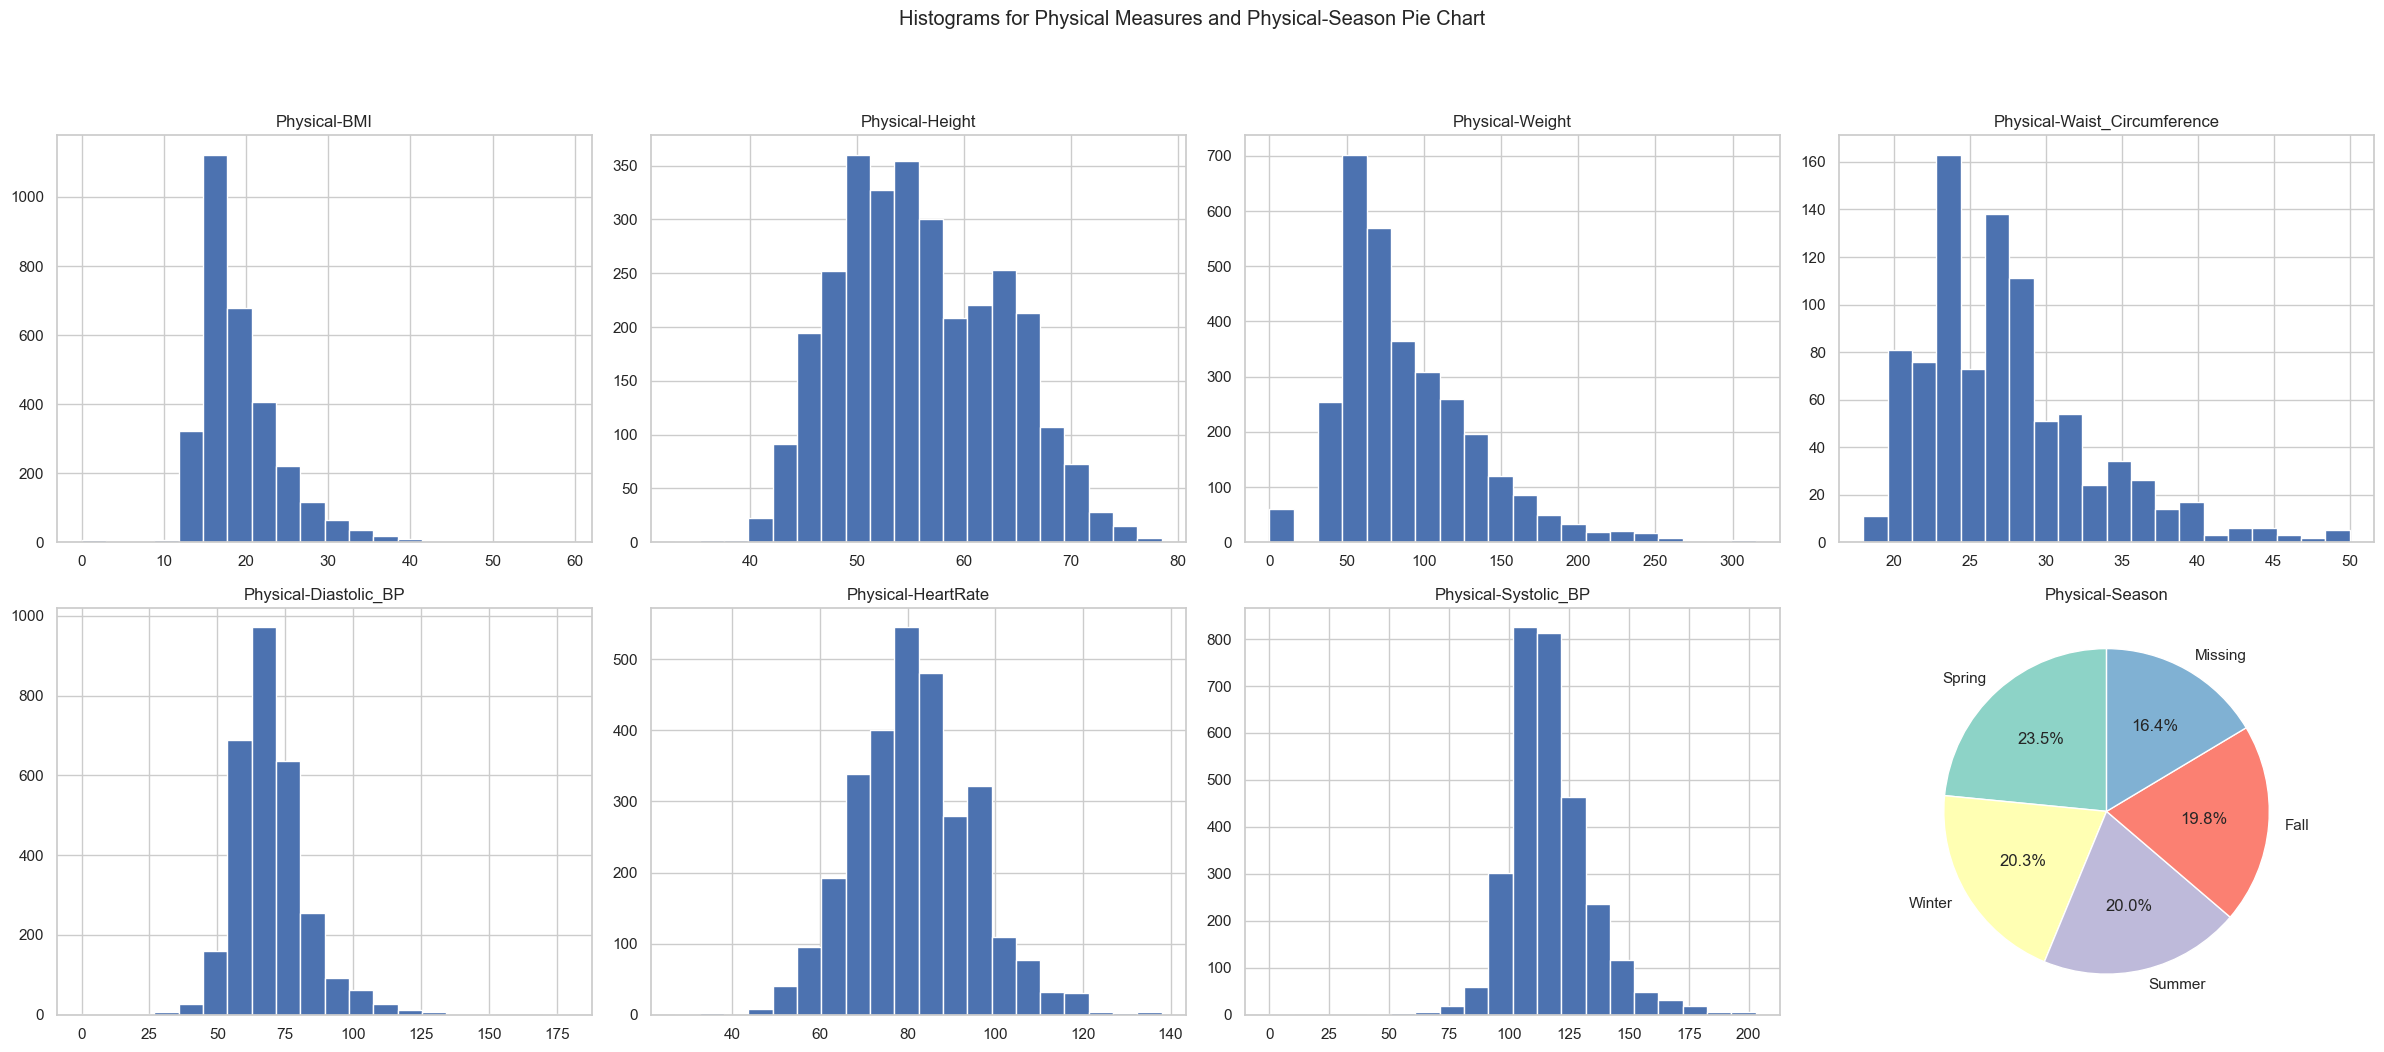

In [423]:
features_physical = groups.get('Physical Measures', [])
cols = [col for col in features_physical if col in continuous_cols]

plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(cols) // n_cols + 1

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train[col].hist(bins=20)
    plt.title(col)

plt.subplot(n_rows, n_cols, len(cols) + 1)
season_counts = train['Physical-Season'].value_counts(dropna=False)
plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('Physical-Season')

plt.suptitle('Histograms for Physical Measures and Physical-Season Pie Chart', y=1.05)
plt.tight_layout()
plt.show()

In [424]:
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048,938
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000,933
Physical-Weight,3076.0,89.038615,44.569040,0.0,57.20000,77.000000,113.800000,315.000000,884
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.0,23.00000,26.000000,30.000000,50.000000,3062
Physical-Diastolic_BP,2954.0,69.648951,13.611226,0.0,61.00000,68.000000,76.000000,179.000000,1006
Physical-HeartRate,2967.0,81.597236,13.665196,27.0,72.00000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2954.0,116.983074,17.061225,0.0,107.00000,114.000000,125.000000,203.000000,1006


### Weight and Height

In [425]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

The minimum values of 0 for measures like BMI, weight, and blood pressure are biologically unrealistic, and likely indicate missing or erroneous data. Let's  check number of zeros in these columns:

In [426]:
(train[wh_cols] == 0).sum()

Physical-BMI                     7
Physical-Height                  0
Physical-Weight                 61
Physical-Waist_Circumference     0
dtype: int64

Replace the 0 values by NaN and check the stats again:

In [427]:
train[wh_cols] = train[wh_cols].replace(0, np.nan)
calculate_stats(train, wh_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.376812,5.034191,8.522436,15.890526,17.950925,21.588631,59.132048,945
Physical-Height,3027.0,55.946713,7.473764,33.000000,50.000000,55.000000,62.000000,78.500000,933
Physical-Weight,3015.0,90.840060,43.161374,31.800000,58.200000,77.800000,114.300000,315.000000,945
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.000000,23.000000,26.000000,30.000000,50.000000,3062


Convert weight to kilograms, and height to centimeters and recalculate BMI:

In [428]:
lbs_to_kg = 0.453592
inches_to_cm = 2.54

train['Physical-Weight'] = train['Physical-Weight'] * lbs_to_kg
train['Physical-Height'] = train['Physical-Height'] * inches_to_cm
train['Physical-Waist_Circumference'] = train['Physical-Waist_Circumference'] * inches_to_cm

# Recalculate BMI: BMI = weight (kg) / (height (m)^2)
train['Physical-BMI'] = np.where(
    train['Physical-Weight'].notna() & train['Physical-Height'].notna(),
    train['Physical-Weight'] / ((train['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

calculate_stats(train, wh_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.378674,5.034658,8.523273,15.892086,17.952687,21.590750,59.137852,945
Physical-Height,3027.0,142.104651,18.983360,83.820000,127.000000,139.700000,157.480000,199.390000,933
Physical-Weight,3015.0,41.204324,19.577654,14.424226,26.399054,35.289458,51.845566,142.881480,945
Physical-Waist_Circumference,898.0,69.287410,14.140909,45.720000,58.420000,66.040000,76.200000,127.000000,3062


A lot of values seem to be out of normal ranges... especially max values of weight (142kg) and waist circumference (127cm).

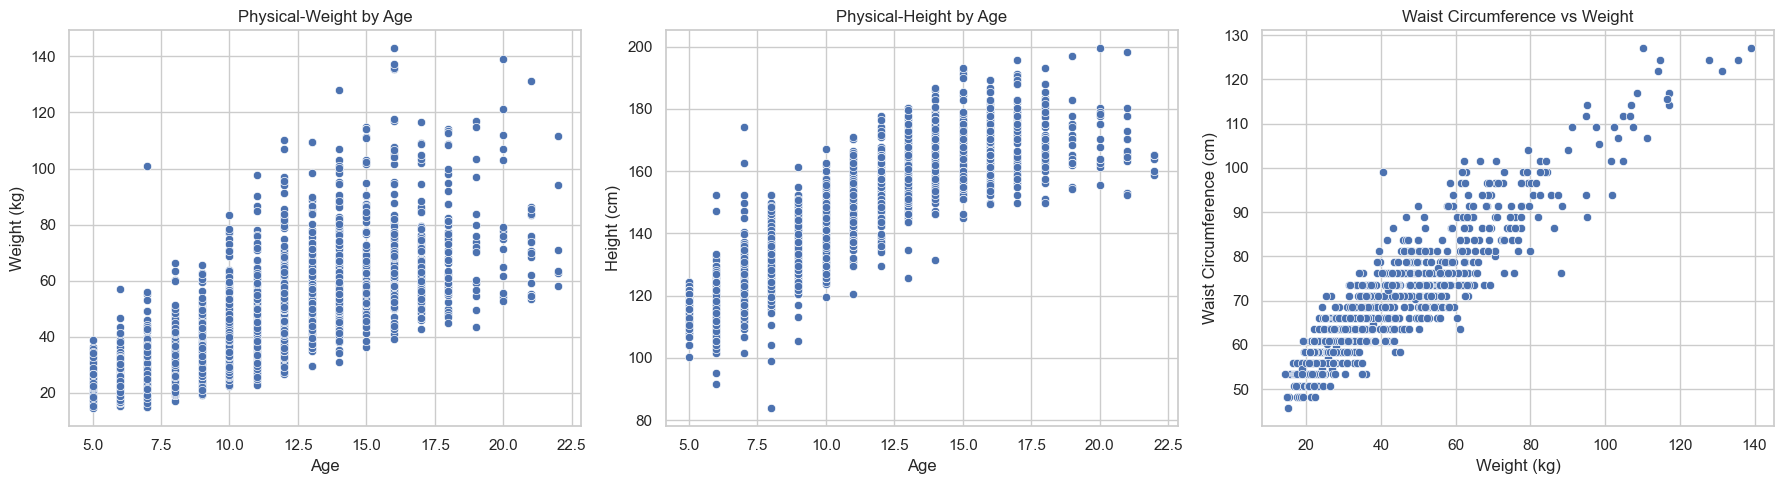

In [429]:
plt.figure(figsize=(18, 5))

# Physical-Weight by Age
plt.subplot(1, 3, 1)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Weight', data=train)
plt.title('Physical-Weight by Age')
plt.xlabel('Age')
plt.ylabel('Weight (kg)')

# Physical-Height by Age
plt.subplot(1, 3, 2)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Height', data=train)
plt.title('Physical-Height by Age')
plt.xlabel('Age')
plt.ylabel('Height (cm)')

# Physical-Waist_Circumference vs Physical-Weight
plt.subplot(1, 3, 3)
sns.scatterplot(x='Physical-Weight', y='Physical-Waist_Circumference', data=train)
plt.title('Waist Circumference vs Weight')
plt.xlabel('Weight (kg)')
plt.ylabel('Waist Circumference (cm)')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>Weight and height both increase with age, and waist circumference and weight are highly correlated, as expected.
<li>However, there are individuals who are unusually tall for their age group or who are extremely overweight.
<li>There are also a few outliers in the waist circumference measurements, which are possible artifacts (e.g. 100 cm for a weight of 40 kg).
<li>The problem with data cleaning here is that we cannot guess which of the data is correct. For example, we may see an unrealistic combination of a waist circumference of 100cm and a weight of 40kg for a participant, but where is the error in the waist circumference or the weight? Or a height of around 175cm for a child of 7... has the height or age been entered incorrectly? Or this is true data and the child has gigantism or another disorder related to the growth hormone?
    </ul>
</div>

### Blood Pressure & Heart Rate

There is 1000% incorrect data in the BP/HR columns as the minimum values are lethal to humans. We can clean up these kinds of mistakes.

In [430]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

In [431]:
(train[bp_hr_cols] < 50).sum()

Physical-Diastolic_BP    88
Physical-Systolic_BP      2
Physical-HeartRate       12
dtype: int64

We also know that systolic BP cannot be lower than diastolic BP:

In [432]:
train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][bp_hr_cols]

,Physical-Diastolic_BP,Physical-Systolic_BP,Physical-HeartRate
1140,179.0,139.0,103.0
1879,117.0,114.0,114.0
2386,76.0,76.0,116.0
3199,0.0,0.0,NaN
3344,98.0,73.0,96.0


These are certainly incorrect measurements. But again, we can't be sure which information is correct, so we can either flag these rows for further manual inspection one by one, or replace all suspicious values with NaN. For this analysis I only remove 0 values and both BP if systolic is lower or equal to diastolic.

In [433]:
train[cols] = train[cols].replace(0, np.nan)
train.loc[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP'], bp_hr_cols] = np.nan

### Blood Pressure vs Heart Rate

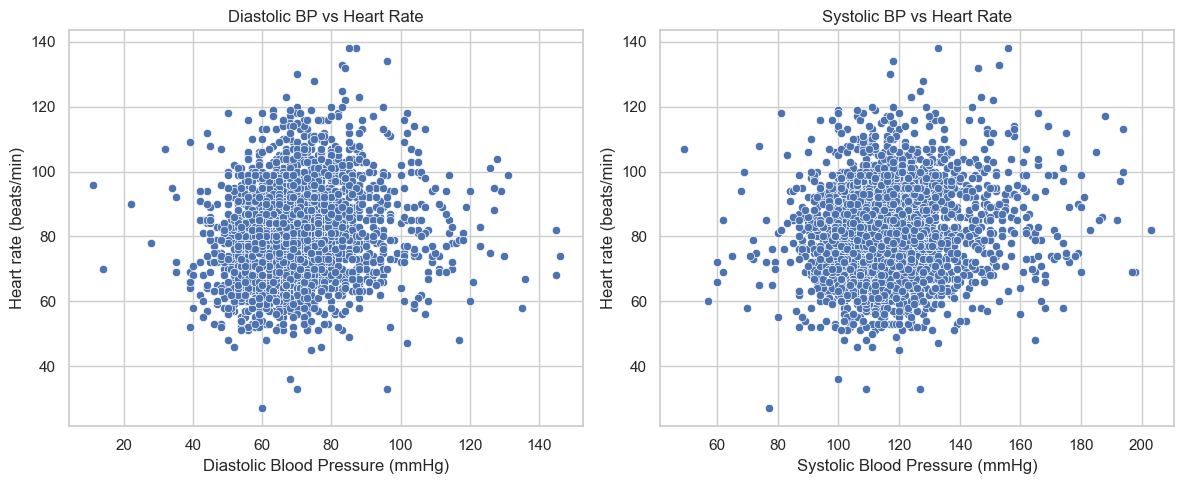

In [434]:
plt.figure(figsize=(12, 5))

# Diastolic BP vs Heart Rate
plt.subplot(1, 2, 1)
sns.scatterplot(x='Physical-Diastolic_BP', y='Physical-HeartRate', data=train)
plt.title('Diastolic BP vs Heart Rate')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

# Systolic BP vs Heart Rate
plt.subplot(1, 2, 2)
sns.scatterplot(x='Physical-Systolic_BP', y='Physical-HeartRate', data=train)
plt.title('Systolic BP vs Heart Rate')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The absence of a clear direct correlation between heart rate and blood pressure in the plots suggests that the measurements were likely taken in a resting state or under non-stressful conditions.
    </ul>
</div>

### Blood pressure vs Body Mass Index (BMI)

Typically, systolic (SBP) and diastolic (DBP) blood pressure are positively correlated, as they both reflect the functioning of the cardiovascular system. However, there can be deviations:

- Isolated Systolic Hypertension: High SBP with normal DBP
- Isolated Diastolic Hypertension: Normal SBP with high DBP
- General Hypertension: Both SBP and DBP are elevated

BMI is often used as an indicator of overall body fat and can correlate with blood pressure (e.g. higher BMI values indicating overweight or obesity are commonly associated with elevated blood pressure). Let's see if this is true for the study participants.

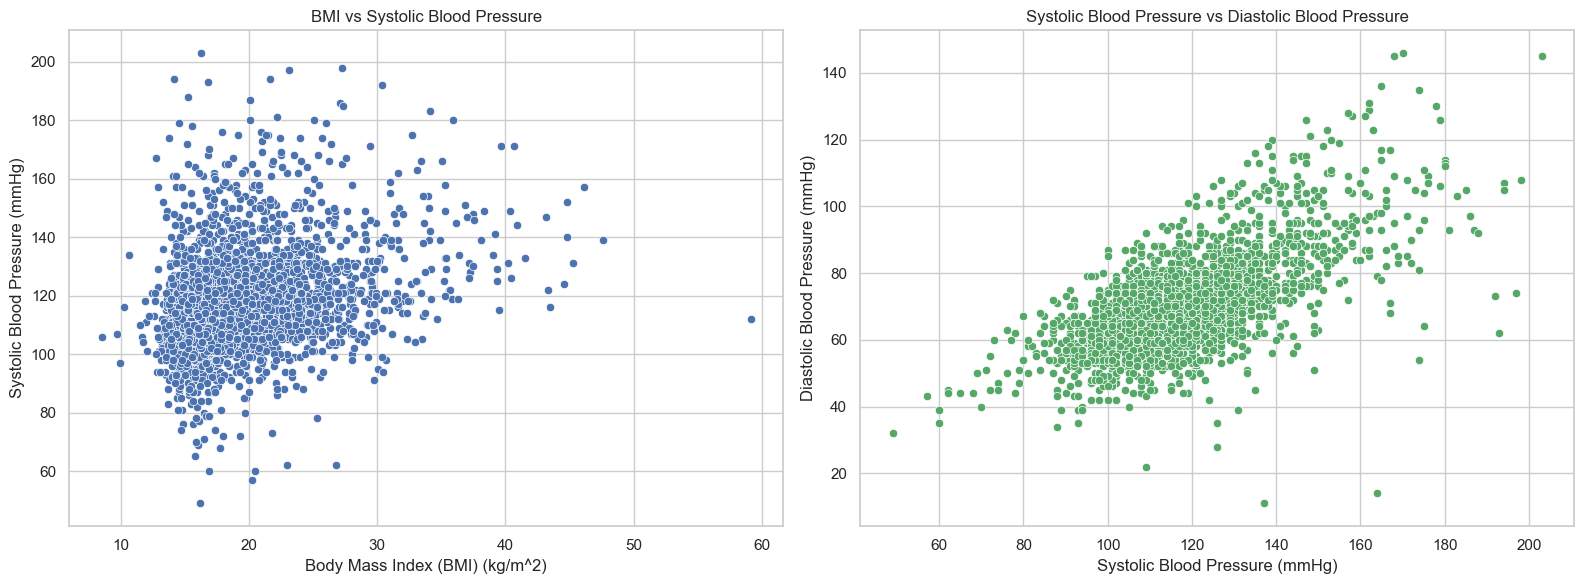

In [435]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BMI vs Systolic Blood Pressure
sns.scatterplot(x='Physical-BMI', y='Physical-Systolic_BP', data=train, ax=axes[0], color='b')
axes[0].set_title('BMI vs Systolic Blood Pressure')
axes[0].set_xlabel('Body Mass Index (BMI) (kg/m^2)')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')

# Systolic Blood Pressure vs Diastolic Blood Pressure
sns.scatterplot(
    x='Physical-Systolic_BP', y='Physical-Diastolic_BP',
    data=train, ax=axes[1], color='g'
)
axes[1].set_title('Systolic Blood Pressure vs Diastolic Blood Pressure')
axes[1].set_xlabel('Systolic Blood Pressure (mmHg)')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>There does not appear to be a strong, clear correlation between body mass index (BMI) and systolic blood pressure (BP).
<li>As expected, there is a strong positive correlation between systolic and diastolic BP, but there are notable cases of isolated systolic or diastolic hypertension (or errors in the data, who knows?)
    </ul>
</div>

### Compare to normal rages

Now we'll define approximate normal ranges for each column and count the number of rows that fall outside these ranges. As normal values can vary widely between the ages of 5 and 22, **I use values that are general estimates; for more precise results you can refer to BMI-for-age growth charts on the CDC or WHO websites, for example.**

In [436]:
normal_ranges = {
    'Physical-BMI': (18.5, 24.9),
    'Physical-Height': (100, 193),
    'Physical-Weight': (20, 120),
    'Physical-Waist_Circumference': (50, 90),
    'Physical-Diastolic_BP': (60, 80),
    'Physical-HeartRate': (60, 100),
    'Physical-Systolic_BP': (90, 120)
}

def count_out_of_range(data, column, low, high):
    return ((data[column] < low) | (data[column] > high)).sum()

In [437]:
out_of_range_counts = {
    col: count_out_of_range(train, col, *normal_ranges[col])
    for col in normal_ranges
}
print("Number of rows with values outside normal ranges:")

for col, count in out_of_range_counts.items():
    total_valid = train[col].notna().sum()
    percentage = (count / total_valid) * 100
    print(f"{col}: {count} ({percentage:.2f}%)")

Number of rows with values outside normal ranges:
Physical-BMI: 2027 (67.23%)
Physical-Height: 10 (0.33%)
Physical-Weight: 165 (5.47%)
Physical-Waist_Circumference: 93 (10.36%)
Physical-Diastolic_BP: 1019 (34.55%)
Physical-HeartRate: 347 (11.71%)
Physical-Systolic_BP: 1075 (36.45%)


Group BMI by obesity level according to [WHO BMI-for-age (5-19 years)](https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age)

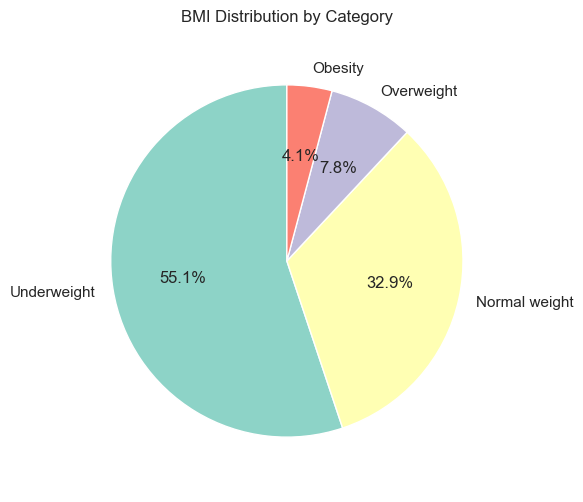

In [438]:
bmi_categories = [
    ('Underweight', train['Physical-BMI'] < 18.5),
    ('Normal weight', (train['Physical-BMI'] >= 18.5) & (train['Physical-BMI'] <= 24.9)),
    ('Overweight', (train['Physical-BMI'] >= 25) & (train['Physical-BMI'] <= 29.9)),
    ('Obesity', train['Physical-BMI'] >= 30)
]
bmi_category_counts = {label: condition.sum() for label, condition in bmi_categories}

plt.figure(figsize=(5, 6))
plt.pie(bmi_category_counts.values(),
        labels=bmi_category_counts.keys(),
        autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3.colors)
plt.title('BMI Distribution by Category')
plt.axis('equal')
plt.show()

### Check extreme deviations cases

In [439]:
train[train['Physical-BMI'] < 12][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-BMI')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
2848,8.523273,149.860,19.141582,NaN,68.0,77.0,106.0,8
1952,9.694718,149.860,21.772416,NaN,64.0,86.0,107.0,7
3463,9.960144,152.400,23.133192,NaN,48.0,73.0,97.0,6
3324,10.282698,147.320,22.316726,NaN,72.0,72.0,116.0,6
1707,10.676487,162.560,28.213422,NaN,99.0,90.0,134.0,7
3143,11.468414,131.318,19.776611,NaN,59.0,77.0,110.0,8
1700,11.676989,167.005,32.567906,NaN,50.0,90.0,106.0,10
3636,11.713943,139.700,22.861037,NaN,58.0,99.0,104.0,7
1307,11.750716,112.522,14.877818,48.26,NaN,77.0,NaN,7
156,11.916424,149.860,26.761928,71.12,76.0,83.0,118.0,11


In [440]:
train[train['Physical-Systolic_BP'] > 160][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-Systolic_BP')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
284,21.719865,152.527,50.530149,NaN,96.0,99.0,161.0,12
882,16.398111,124.460,25.401152,NaN,127.0,95.0,161.0,6
2401,17.245599,129.540,28.939170,NaN,87.0,103.0,161.0,8
1794,14.036968,121.920,20.865232,NaN,111.0,69.0,161.0,8
3032,14.272220,129.540,23.949658,NaN,104.0,89.0,161.0,9
...,...,...,...,...,...,...,...,...
1019,14.172653,124.460,21.953853,60.96,107.0,113.0,194.0,8
2777,21.625191,134.620,39.190349,NaN,105.0,100.0,194.0,7
2549,23.154916,169.926,66.859461,NaN,74.0,69.0,197.0,17
436,27.260353,175.260,83.733083,NaN,108.0,69.0,198.0,19


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
        <li>A significant number of participants, especially for BMI and blood pressure, fall outside the expected normal ranges
        <li>Most participants' heights and weights are within reasonable ranges, but many have BMIs outside the approximate normal range, suggesting that many participants may have disproportionate body proportions (or incorrect measurements?). For a more accurate understanding, age-specific reference values need to be used.
    </ul>
</div>

### Relationships with the target variable (PCIAT_Total for complete PCIAT responses)

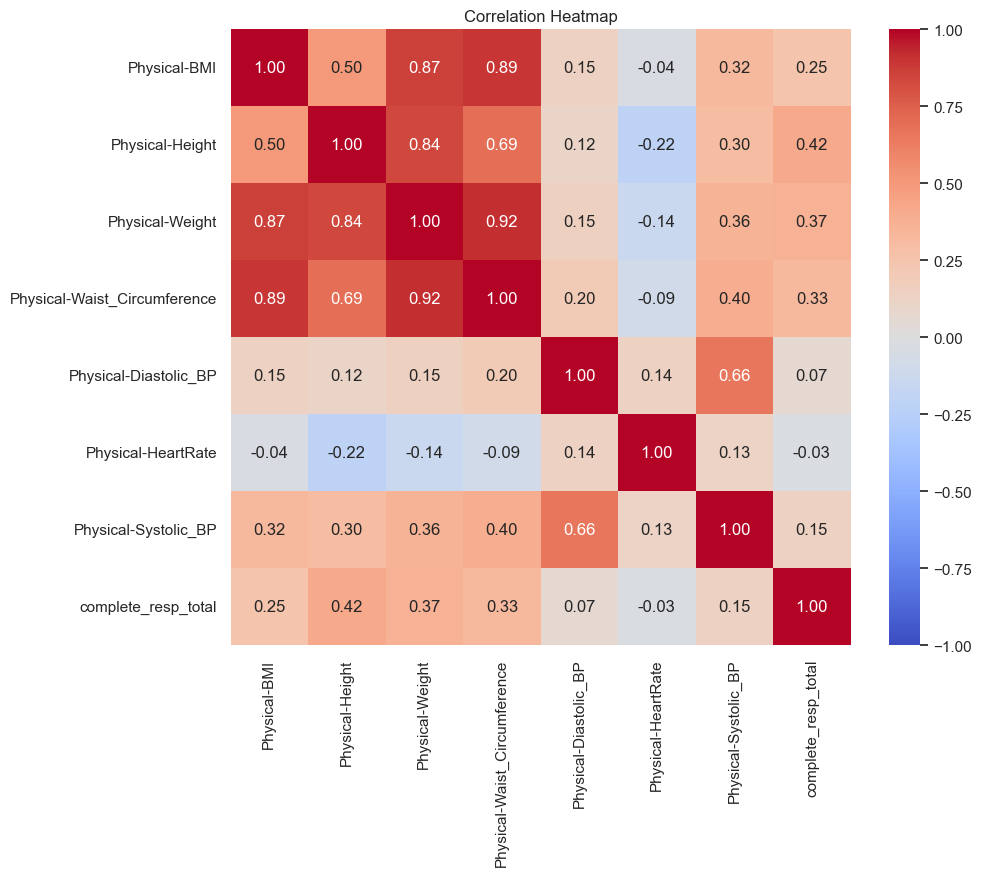

In [441]:
data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The positive correlation with the target is for height, weight, and waist circumference, which means that taller and fatter people tend to have a higher SII. But as these physical parameters increase with age, and we already know that SII tends to be highest in adolescents, this could indicate that they acts as a proxy for age (likely reflect age-related trends).
<li>Cardiovascular measures (systolic blood pressure, diastolic blood pressure and heart rate) also change with age, but do not vary as drastically between childhood and adolescence as physical measures, and may not be as sensitive to behaviours such as internet use. They also have a higher degree of variability, as we saw in the graphs above, so the weak correlation may indicate that cardiovascular health is not strongly linked to PIU, or that these data are just more scattered and noisy and the relationship with PIU is diluted.
    </ul>
</div>

# - Bio-electric Impedance Analysis

In [442]:
data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


There is no information in the competition description about what equipment was used, is this raw data or did they use some BIA equation models to estimate the parameters. But it's likely that the BIA data has already been processed using a BIA equation model. It is very important to note that BIA is not a precise method, for example it tends to overestimate muscle mass, so equations have been developed to estimate muscle mass based on factors such as age, sex, height, weight and resistance and/or reactance estimated by BIA... a large number of prediction equation models have been generated through various validation studies ([link](https://clinicalnutritionespen.com/article/S2405-4577(19)30478-4/fulltext)). It is essential that all recordings are processed with the same equation, but we cannot be sure.

In [443]:
bia_data_dict = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']
categorical_columns = bia_data_dict[bia_data_dict['Type'] == 'categorical int']['Field'].tolist()
continuous_columns = bia_data_dict[bia_data_dict['Type'] == 'float']['Field'].tolist()

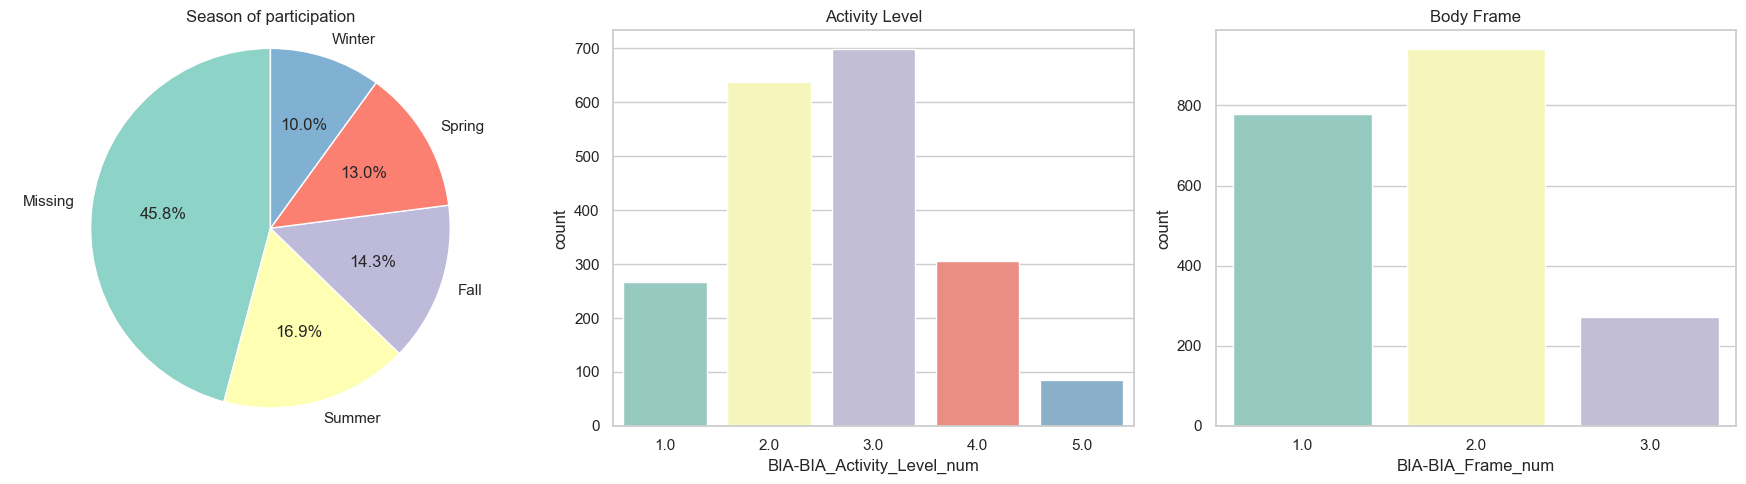

In [444]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Season
season_counts = train['BIA-Season'].value_counts(normalize=True)
axes[0].pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
axes[0].set_title(
    f"{bia_data_dict[bia_data_dict['Field'] == 'BIA-Season']['Description'].values[0]}"
)
axes[0].axis('equal')

# Other categorical columns
for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, palette="Set3", ax=axes[idx+1])
    axes[idx+1].set_title(data_dict[data_dict['Field'] == col]['Description'].values[0])

plt.tight_layout()
plt.show()

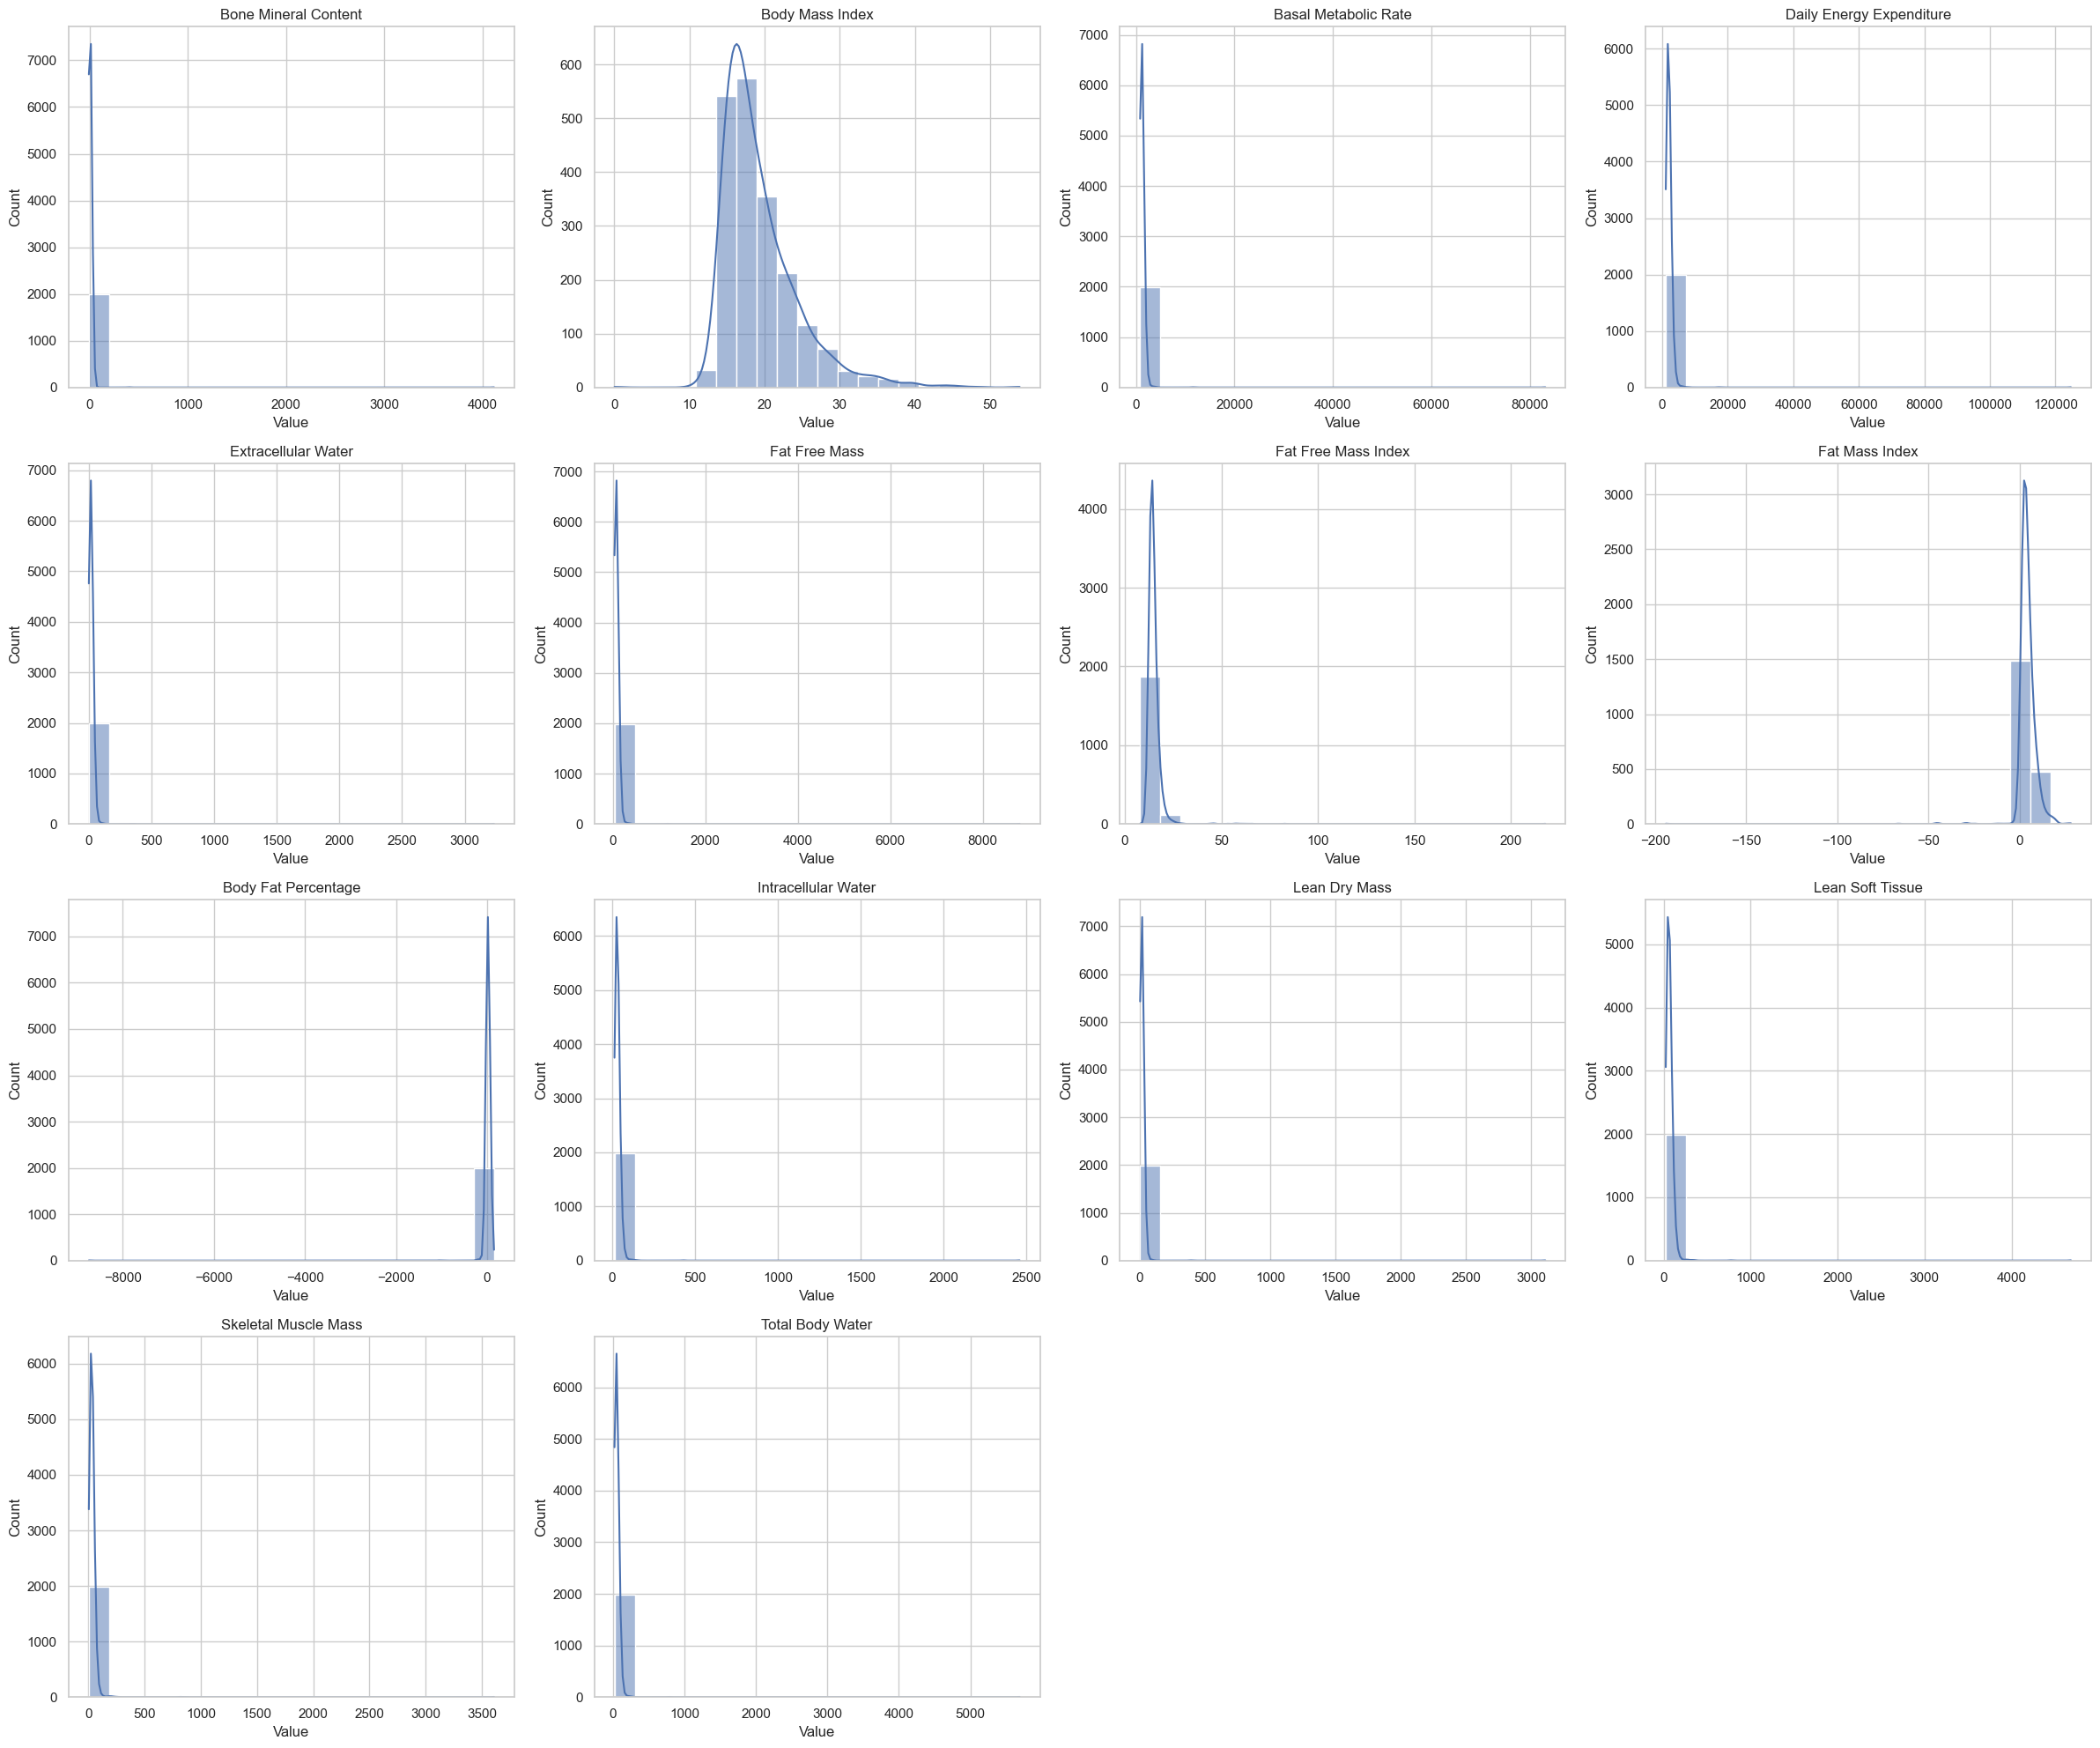

In [445]:
plt.figure(figsize=(24, 20))

for idx, col in enumerate(continuous_columns):
    plt.subplot(4, 4, idx + 1)
    sns.histplot(train[col].dropna(), bins=20, kde=True)
    plt.title(data_dict[data_dict['Field'] == col]['Description'].values[0])
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [446]:
calculate_stats(train, continuous_columns)

,count,mean,std,min,25%,50%,75%,max,missing
BIA-BIA_BMC,1991.0,6.719826,92.586325,-7.789610,2.966905,3.92272,5.460925,4115.3600,1969
BIA-BIA_BMI,1991.0,19.367048,5.047848,0.048267,15.913600,17.96650,21.461100,53.9243,1969
BIA-BIA_BMR,1991.0,1237.018187,1872.383246,813.397000,1004.710000,1115.38000,1310.360000,83152.2000,1969
BIA-BIA_DEE,1991.0,2064.693747,2836.246272,1073.450000,1605.785000,1863.98000,2218.145000,124728.0000,1969
BIA-BIA_ECW,1991.0,20.825346,73.266287,1.789450,11.109550,15.92800,25.162200,3233.0000,1969
BIA-BIA_FFM,1991.0,74.021708,199.433753,28.900400,49.278100,61.06620,81.833800,8799.0800,1969
BIA-BIA_FFMI,1991.0,15.030554,5.792505,7.864850,13.408000,14.09250,15.430950,217.7710,1969
BIA-BIA_FMI,1991.0,4.336495,6.356402,-194.163000,2.306915,3.69863,5.987690,28.2515,1969
BIA-BIA_Fat,1991.0,16.855020,199.372119,-8745.080000,8.602395,16.17460,30.273100,153.8200,1969
BIA-BIA_ICW,1991.0,33.173380,56.272346,14.489000,24.463500,28.85580,35.475700,2457.9100,1969


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The distribution of the various bioelectrical impedance analysis measurements in the data set indicates that most of them are not useful: highly skewed, with the majority of participants having marginal values and a few outliers (potential measurement errors).
<li>Some variables, such as Fat Mass Index and Body Fat Percentage, show implausible negative values, and almost all - extreme high values, indicating potential data quality issues
    </ul>
</div>

### Compare the two measured BMI

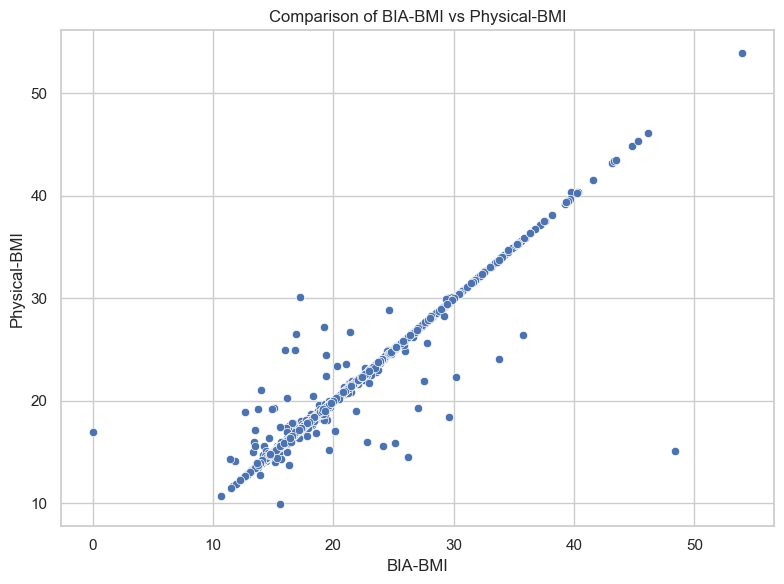

In [447]:
bmi_data = train[['BIA-BIA_BMI', 'Physical-BMI']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='BIA-BIA_BMI', y='Physical-BMI',
    data=bmi_data,
    color='b'
)
plt.title('Comparison of BIA-BMI vs Physical-BMI')
plt.xlabel('BIA-BMI')
plt.ylabel('Physical-BMI')

plt.tight_layout()
plt.show()

In [448]:
bmi_measures = train[['BIA-Season', 'Physical-Season']].dropna()
bmi_measures.groupby(['BIA-Season', 'Physical-Season']).size().reset_index(name='Count')

,BIA-Season,Physical-Season,Count
0,Fall,Fall,407
1,Fall,Missing,6
2,Fall,Spring,15
3,Fall,Summer,131
4,Fall,Winter,8
5,Missing,Fall,294
6,Missing,Missing,635
7,Missing,Spring,309
8,Missing,Summer,277
9,Missing,Winter,300


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note: This may not be exactly correct, because above I found zeros in the physical measurements and recalculated the BMI... As we can see, this BMI measured during the bioelectrical impedance also contains zeros that I cannot explain and that seem to be errors.
</div>

I am afraid that it will be meaningless to examine the relationships with the target variable, as there is too much unknown about these data (how they were collected and processed, what the reference values are, etc.).

# - FitnessGram

## FitnessGram Vitals and Treadmill

In [449]:
groups.get('FitnessGram Vitals and Treadmill', [])

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [450]:
data = train[train['Fitness_Endurance-Max_Stage'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with Fitness_Endurance-Max_Stage data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with Fitness_Endurance-Max_Stage data: 6 - 12 years


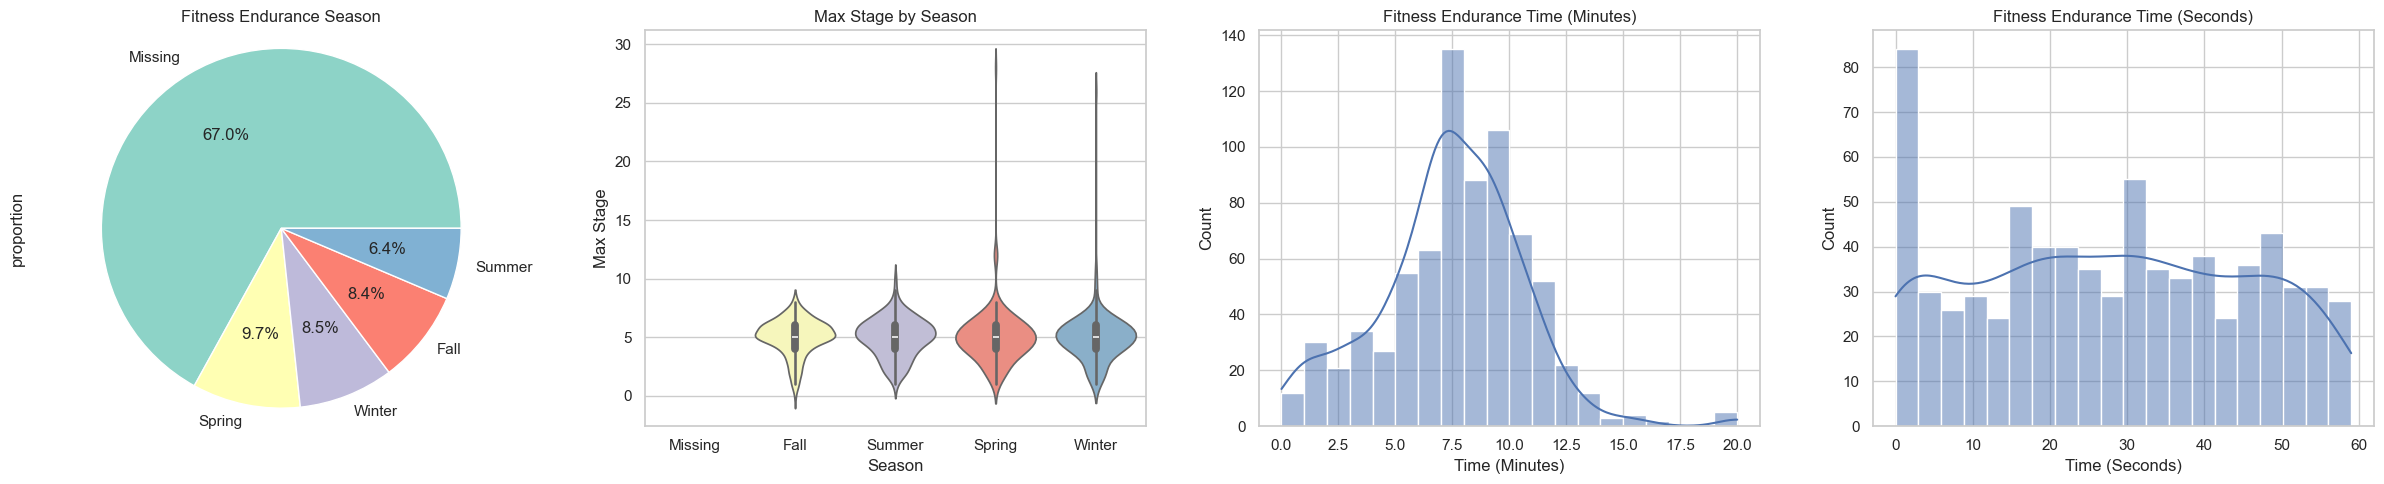

In [451]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Fitness Endurance Season
train['Fitness_Endurance-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors, ax=axes[0]
)
axes[0].set_title('Fitness Endurance Season')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Box plot for Max Stage by Season
sns.violinplot(
    x='Fitness_Endurance-Season',
    y='Fitness_Endurance-Max_Stage',
    data=train, palette="Set3",
    ax=axes[1]
)
axes[1].set_title('Max Stage by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Max Stage')

# Fitness Endurance Time (Minutes)
sns.histplot(train['Fitness_Endurance-Time_Mins'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Fitness Endurance Time (Minutes)')
axes[2].set_xlabel('Time (Minutes)')

# Fitness Endurance Time (Seconds)
sns.histplot(train['Fitness_Endurance-Time_Sec'], bins=20, kde=True, ax=axes[3])
axes[3].set_title('Fitness Endurance Time (Seconds)')
axes[3].set_xlabel('Time (Seconds)')

plt.tight_layout()
plt.show()

Endurance by age:

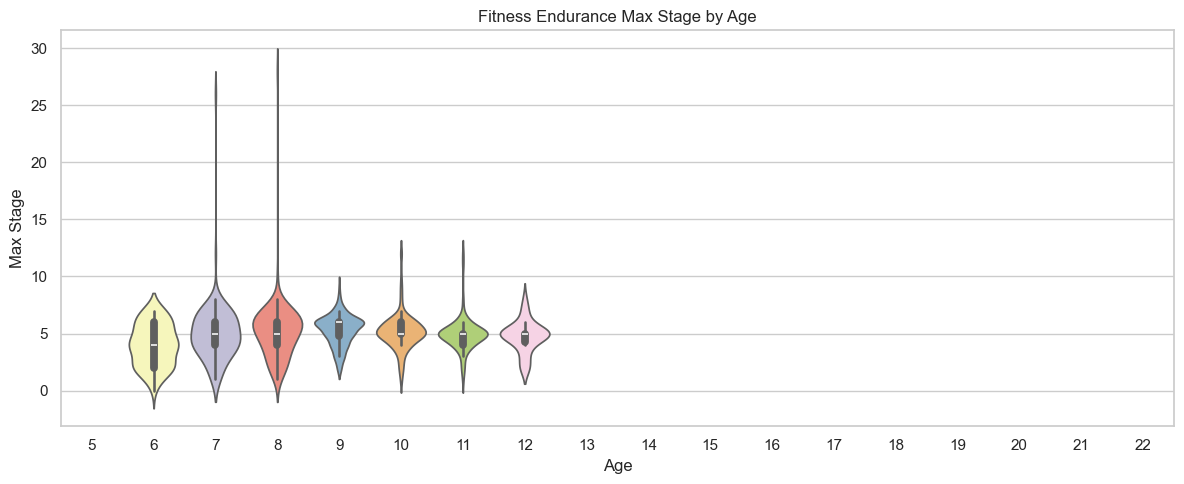

In [452]:
plt.figure(figsize=(12, 5))

sns.violinplot(x='Basic_Demos-Age', y='Fitness_Endurance-Max_Stage', data=train, palette="Set3")
plt.title('Fitness Endurance Max Stage by Age')
plt.xlabel('Age')
plt.ylabel('Max Stage')

plt.tight_layout()
plt.show()

In [453]:
cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,743.0,4.989233,2.014072,0.0,4.00,5.0,6.0,28.0,3217
Fitness_Endurance-Time_Mins,740.0,7.370270,3.189662,0.0,6.00,7.0,9.0,20.0,3220
Fitness_Endurance-Time_Sec,740.0,27.581081,17.707751,0.0,12.75,28.0,43.0,59.0,3220


- Fitness_Endurance-Max_Stage: likely represents the maximum stage reached during an endurance test. In fitness endurance tests like a treadmill test or a multi-stage fitness test (beep test), participants progress through increasing levels of difficulty (speed or incline), and this column records the highest level or stage completed by the participant before stopping.
- Fitness_Endurance-Time_Mins: could be the duration a participant was able to sustain the test before reaching exhaustion, measured in minutes
- Fitness_Endurance-Time_Sec: I guess combining both columns (minutes and seconds) would give the exact total time of the endurance test completed by the participants.

### Check the combinations of missing values

Max_Stage present, time (mins or secs) missing:

In [454]:
train[
    (train['Fitness_Endurance-Max_Stage'].notna()) &
    (train['Fitness_Endurance-Time_Mins'].isna() |
     train['Fitness_Endurance-Time_Sec'].isna())
][cols]

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec
420,4.0,6.0,NaN
1470,26.0,NaN,NaN
2907,1.0,NaN,26.0
3666,2.0,NaN,NaN


It's possible that during data entry minutes or seconds were left blank (entered as NaN) when they should have been recorded as 0 minutes/seconds. While the missing seconds are not as important, the missing minutes may actually be missing and treating them as 0 would give an incorrect test result. I think it's better to just remove these suspicious cases.

In [455]:
train.loc[
    (train['Fitness_Endurance-Max_Stage'].notna()) &
    (train['Fitness_Endurance-Time_Mins'].isna() |
     train['Fitness_Endurance-Time_Sec'].isna()), cols
] = np.nan

Get one time column (mins + sec)

In [456]:
train['Fitness_Endurance-Total_Time_Sec'] = train[
    'Fitness_Endurance-Time_Mins'
] * 60 + train['Fitness_Endurance-Time_Sec']

Recalculate stats:

In [457]:
calculate_stats(train, ['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,739.0,4.971583,1.856069,0.0,4.0,5.0,6.0,28.0,3221
Fitness_Endurance-Total_Time_Sec,739.0,469.910690,188.716073,5.0,362.0,476.0,590.5,1200.0,3221


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>On average, participants reached stage 5 in the endurance test.
<li>Some participants failed to complete the first stage (min = 0), or these are errors in data again.
<li>There is a small number of participants with exceptionally high endurance of age 7-8 years.
<li>There is a substantial amount of missing data (over 80% of the dataset lacks this information).
    </ul>
</div>

## FitnessGram Child

In [458]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


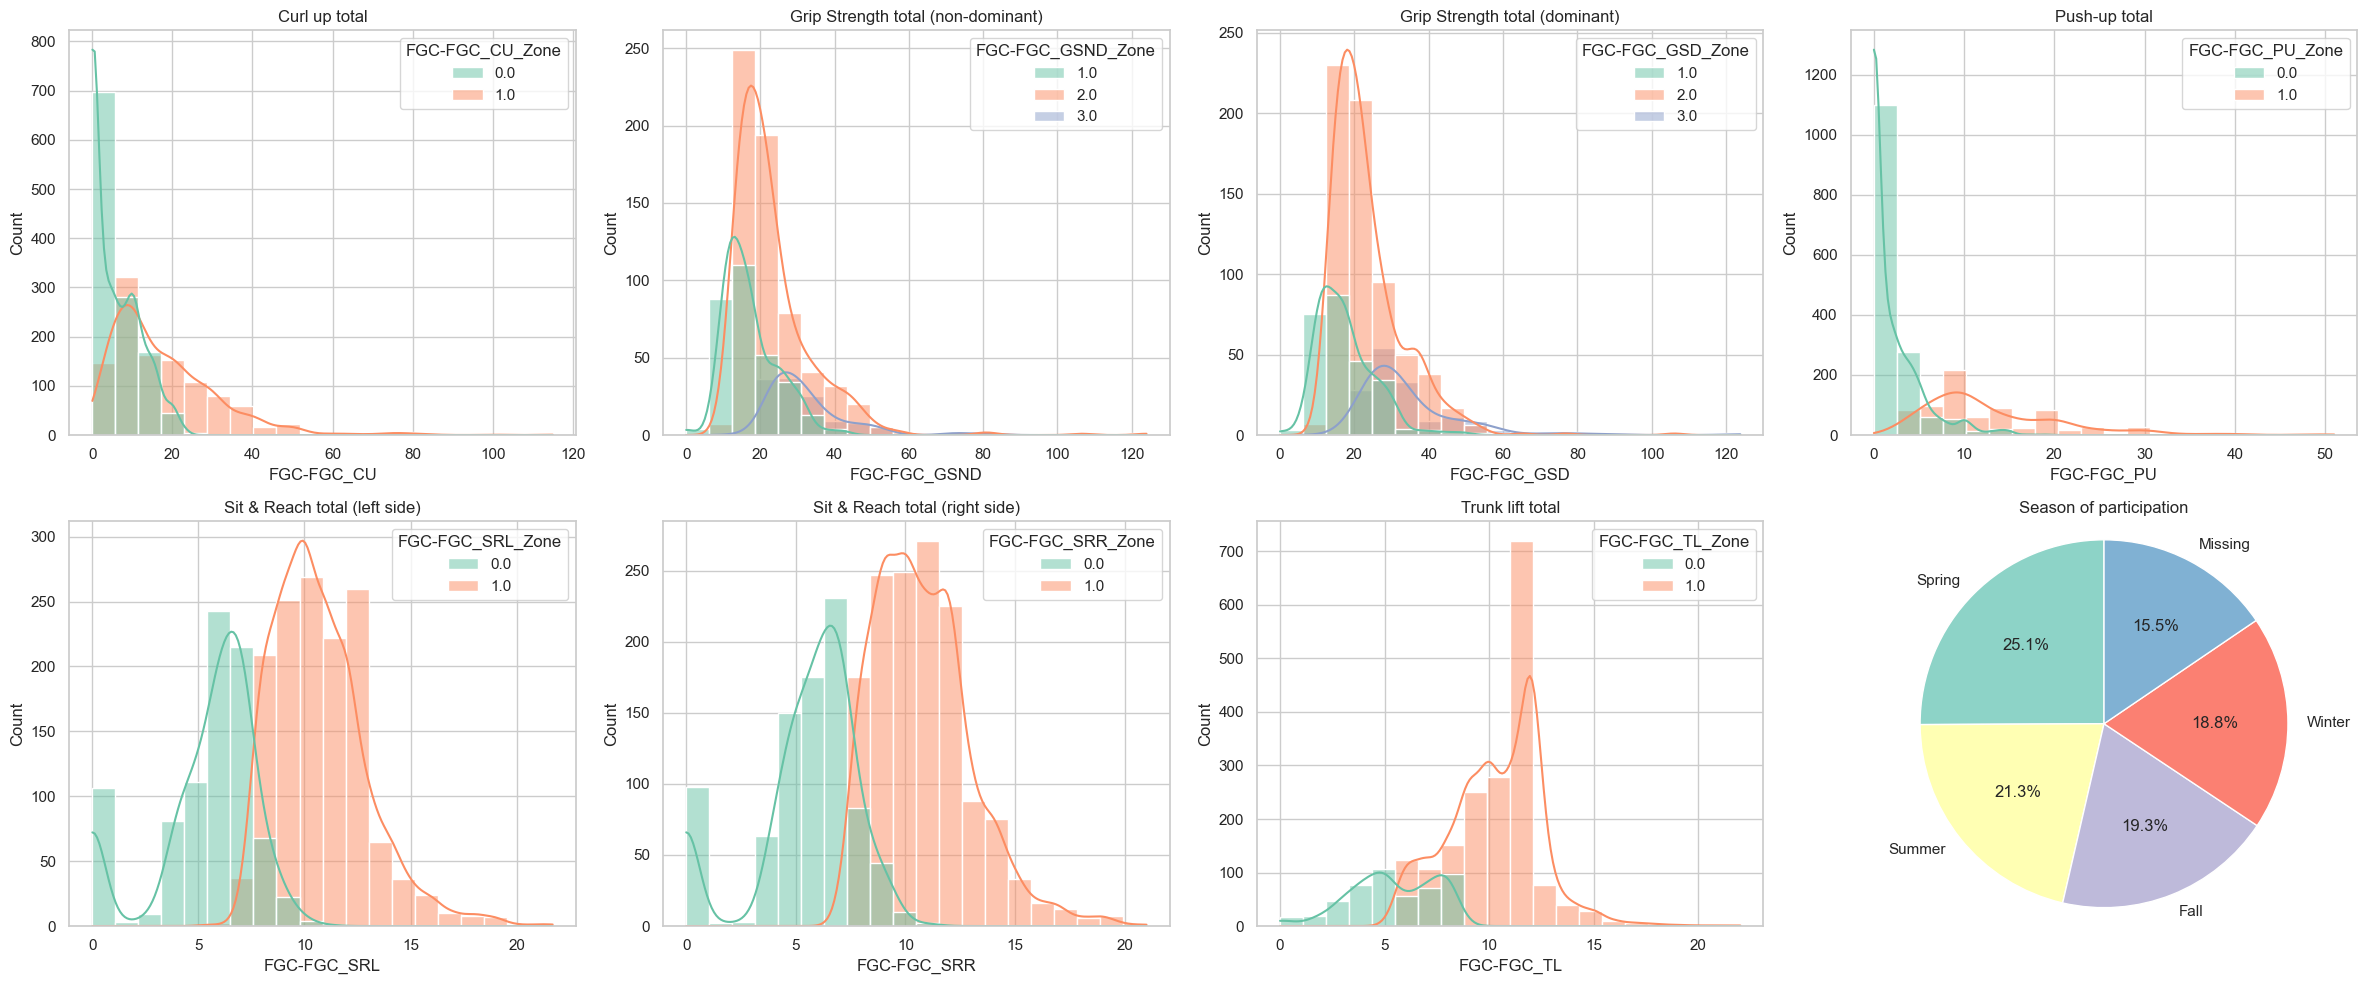

In [459]:
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']

        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]

        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))

fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4

    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>Most of the distributions are skewed towards lower performance totals.
<li>Strangely, a greater proportion of participants achieved a healthy fitness zone for the trunk lift.
<li>I would expect different ranges for each zone, but the values for different zones overlap significantly. This may be because the zone ranges are different for different ages.
    </ul>
</div>

In [460]:
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2322.0,11.259690,11.807781,0.0,3.0,9.00,15.750,115.0,1638
FGC-FGC_GSND,1074.0,22.420438,10.833995,0.0,15.1,20.05,26.600,124.0,2886
FGC-FGC_GSD,1074.0,23.518622,11.148951,0.0,16.2,21.20,28.175,123.8,2886
FGC-FGC_PU,2310.0,5.579654,7.390161,0.0,0.0,3.00,9.000,51.0,1650
FGC-FGC_SRL,2305.0,8.694924,3.429301,0.0,7.0,9.00,11.000,21.7,1655
FGC-FGC_SRR,2307.0,8.805635,3.422167,0.0,7.0,9.00,11.000,21.0,1653
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.000,22.0,1636


### Overlap between fitness zones

In [461]:
def compute_min_max_by_sex(train, sex, fgc_columns):
    results = []

    for measure, zone, _, _ in fgc_columns:
        sorted_zones = sorted(train[zone].dropna().unique())

        for zone_value in sorted_zones:
            data = train[(train[zone] == zone_value) &
                         (train['Basic_Demos-Sex'] == sex)][measure]

            if not data.empty:
                min_val, max_val = data.min(), data.max()
                results.append({
                    'Zone': int(zone_value),
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })

    df = pd.DataFrame(results).pivot_table(
        index='Zone', columns='Measure', values='Min-Max', aggfunc='first'
    )

    return df

Output ranges for each measure and zone for males:

In [462]:
compute_min_max_by_sex(train, 'Male', fgc_columns)

Measure,FGC-FGC_CU,FGC-FGC_GSD,FGC-FGC_GSND,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL
Zone,,,,,,,
0,0.0 - 23.0,NaN,NaN,0.0 - 19.0,0.0 - 7.75,0.0 - 8.0,0.0 - 8.2
1,2.0 - 85.0,0.0 - 46.8,0.0 - 43.0,3.0 - 51.0,7.5 - 20.0,7.0 - 19.0,5.5 - 21.0
2,NaN,12.7 - 106.0,12.6 - 106.4,NaN,NaN,NaN,NaN
3,NaN,22.5 - 123.8,22.6 - 81.8,NaN,NaN,NaN,NaN


Same for females;

In [463]:
compute_min_max_by_sex(train, 'Female', fgc_columns)

Measure,FGC-FGC_CU,FGC-FGC_GSD,FGC-FGC_GSND,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL
Zone,,,,,,,
0,0.0 - 17.0,NaN,NaN,0.0 - 6.0,0.0 - 11.0,0.0 - 11.0,0.0 - 8.5
1,2.0 - 115.0,5.1 - 49.8,0.0 - 36.2,3.0 - 50.0,5.5 - 21.7,8.5 - 21.0,5.5 - 22.0
2,NaN,9.5 - 65.2,9.0 - 124.0,NaN,NaN,NaN,NaN
3,NaN,16.3 - 88.8,15.5 - 74.0,NaN,NaN,NaN,NaN


The ranges for each measure and zone by age (only for males, just to check if the overlap still exists):

In [464]:
results_male = []

for measure, zone, _, _ in fgc_columns:
    sorted_zones = sorted(train[zone].dropna().unique())
    for zone_value in sorted_zones:
        age_sex_data_by_zone = train[train[zone] == zone_value][
            ['Basic_Demos-Age', 'Basic_Demos-Sex', measure]
        ]
        unique_ages = age_sex_data_by_zone['Basic_Demos-Age'].dropna().unique()

        for age in sorted(unique_ages):
            age_sex_data = age_sex_data_by_zone[
                (age_sex_data_by_zone['Basic_Demos-Age'] == age) &
                (age_sex_data_by_zone['Basic_Demos-Sex'] == 'Male')
            ][measure]

            if not age_sex_data.empty:
                min_val, max_val = age_sex_data.min(), age_sex_data.max()
                results_male.append({
                    'Age': age,
                    'Sex': 'Male',
                    'Zone': zone_value,
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })

df_male = pd.DataFrame(results_male).pivot_table(
    index=['Age', 'Sex', 'Zone'], columns='Measure', values='Min-Max', aggfunc='first'
)

df_male

Measure         FGC-FGC_CU   FGC-FGC_GSD  FGC-FGC_GSND   FGC-FGC_PU  \
Age Sex  Zone                                                         
5   Male 0.0     0.0 - 1.0           NaN           NaN    0.0 - 2.0   
         1.0    2.0 - 13.0           NaN           NaN    3.0 - 8.0   
6   Male 0.0     0.0 - 1.0           NaN           NaN    0.0 - 2.0   
         1.0    2.0 - 40.0           NaN           NaN   3.0 - 20.0   
7   Male 0.0     0.0 - 3.0           NaN           NaN    0.0 - 3.0   
         1.0    2.0 - 30.0           NaN           NaN   3.0 - 24.0   
8   Male 0.0     0.0 - 5.0           NaN           NaN    0.0 - 5.0   
         1.0    4.0 - 30.0           NaN           NaN   4.0 - 40.0   
9   Male 0.0    0.0 - 10.0           NaN           NaN    0.0 - 5.0   
         1.0    6.0 - 43.0   11.1 - 11.1           NaN   5.0 - 30.0   
         2.0           NaN   13.3 - 13.3   12.7 - 13.1          NaN   
10  Male 0.0    0.0 - 11.0           NaN           NaN    0.0 - 6.0   
         1.0    9.0 - 75.0    0.0 - 16.1    0.0 - 15.1   6.0 - 37.0   
         2.0           NaN   12.7 - 44.0   12.6 - 34.0          NaN   
         3.0           NaN   25.9 - 29.3   22.9 - 50.2          NaN   
11  Male 0.0    0.0 - 14.0           NaN           NaN    0.0 - 7.0   
         1.0   12.0 - 50.0    6.3 - 24.6    8.6 - 24.6   7.0 - 50.0   
         2.0           NaN   12.8 - 35.4   12.7 - 49.0          NaN   
         3.0           NaN   22.5 - 53.6   22.6 - 49.8          NaN   
12  Male 0.0    0.0 - 17.0           NaN           NaN    0.0 - 9.0   
         1.0   15.0 - 45.0    9.9 - 40.6    9.9 - 41.8   8.0 - 30.0   
         2.0           NaN   13.1 - 49.0   12.6 - 48.2          NaN   
         3.0           NaN   22.8 - 46.8   23.0 - 41.7          NaN   
13  Male 0.0    0.0 - 20.0           NaN           NaN   0.0 - 19.0   
         1.0   18.0 - 80.0   11.3 - 37.2    8.9 - 31.4  10.0 - 40.0   
         2.0           NaN   19.1 - 47.8   17.7 - 45.6          NaN   
         3.0           NaN   32.5 - 42.2   31.6 - 42.6          NaN   
14  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 13.0   
         1.0   24.0 - 80.0   12.8 - 46.8   11.5 - 43.0  13.0 - 37.0   
         2.0           NaN   19.7 - 42.9   20.2 - 56.8          NaN   
         3.0           NaN   31.5 - 79.2   31.8 - 81.8          NaN   
15  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 14.0   
         1.0   24.0 - 85.0    0.0 - 43.4    0.0 - 39.4  15.0 - 49.0   
         2.0           NaN   22.6 - 76.8   17.5 - 80.4          NaN   
         3.0           NaN   28.1 - 49.6   33.6 - 47.1          NaN   
16  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 15.0   
         1.0   24.0 - 64.0   16.1 - 32.3   15.3 - 32.0  16.0 - 39.0   
         2.0           NaN   29.2 - 47.9   21.6 - 46.6          NaN   
         3.0           NaN   46.6 - 57.6   44.0 - 47.4          NaN   
17  Male 0.0    0.0 - 22.0           NaN           NaN   0.0 - 15.0   
         1.0   24.0 - 78.0   11.1 - 32.3   12.4 - 31.9  18.0 - 47.0   
         2.0           NaN  17.8 - 106.0  30.4 - 106.4          NaN   
         3.0           NaN  34.4 - 123.8   33.3 - 53.7          NaN   
18  Male 0.0    0.0 - 23.0           NaN           NaN   5.0 - 14.0   
         1.0   25.0 - 40.0           NaN   28.4 - 33.8  23.0 - 51.0   
         2.0           NaN   24.4 - 52.0   20.2 - 42.1          NaN   
         3.0           NaN   28.4 - 28.4   23.4 - 52.7          NaN   
19  Male 0.0    8.0 - 20.0           NaN           NaN    8.0 - 8.0   
         1.0           NaN   23.9 - 31.1   26.0 - 26.1  18.0 - 18.0   
20  Male 0.0           NaN           NaN           NaN  17.0 - 17.0   
         1.0   34.0 - 34.0           NaN           NaN          NaN   
         3.0           NaN   56.8 - 56.8   52.5 - 52.5          NaN   
21  Male 0.0   20.0 - 20.0           NaN           NaN  11.0 - 11.0   
         1.0   30.0 - 30.0           NaN   23.3 - 23.3  20.0 - 20.0   
         2.0           N

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The table shows the min-max ranges for various fitness measures (such as curl-ups, grip strength, push-ups, sit-and-reach, and trunk lifts) across different ages and zones.
<li>There is a significant overlap in min-max ranges across different zones within the same age group for some measures. For example, at age 9: 6 to 10 curl-ups may correspond to Zone 0 (Needs Improvement) or Zone 1 (Healthy Fitness Zone).
<li>This overlap indicates that the criteria for each zone are not sharply defined by specific ranges, even for the same age, and these zone columns appear to be features that just add extra noise, I would not use them in modelling.
    </ul>
</div>


### Age Ranges for each measurement column

In [465]:
age_ranges = []

for measure in measurement_columns:
    valid_rows = train[~train[measure].isna()]

    min_age = valid_rows['Basic_Demos-Age'].min()
    max_age = valid_rows['Basic_Demos-Age'].max()

    age_ranges.append({
        'Measurement': measure,
        'Min Age': min_age,
        'Max Age': max_age
    })

age_ranges_df = pd.DataFrame(age_ranges)
age_ranges_df

,Measurement,Min Age,Max Age
0,FGC-FGC_CU,5,21
1,FGC-FGC_GSND,6,21
2,FGC-FGC_GSD,6,21
3,FGC-FGC_PU,5,21
4,FGC-FGC_SRL,5,21
5,FGC-FGC_SRR,5,21
6,FGC-FGC_TL,5,21


In addition, it also doesn't make sense to call this a children's FitnessGram, since participants of almost all ages (5-21) were tested.

## Relationships with the target variable (PCIAT_Total for complete PCIAT responses)

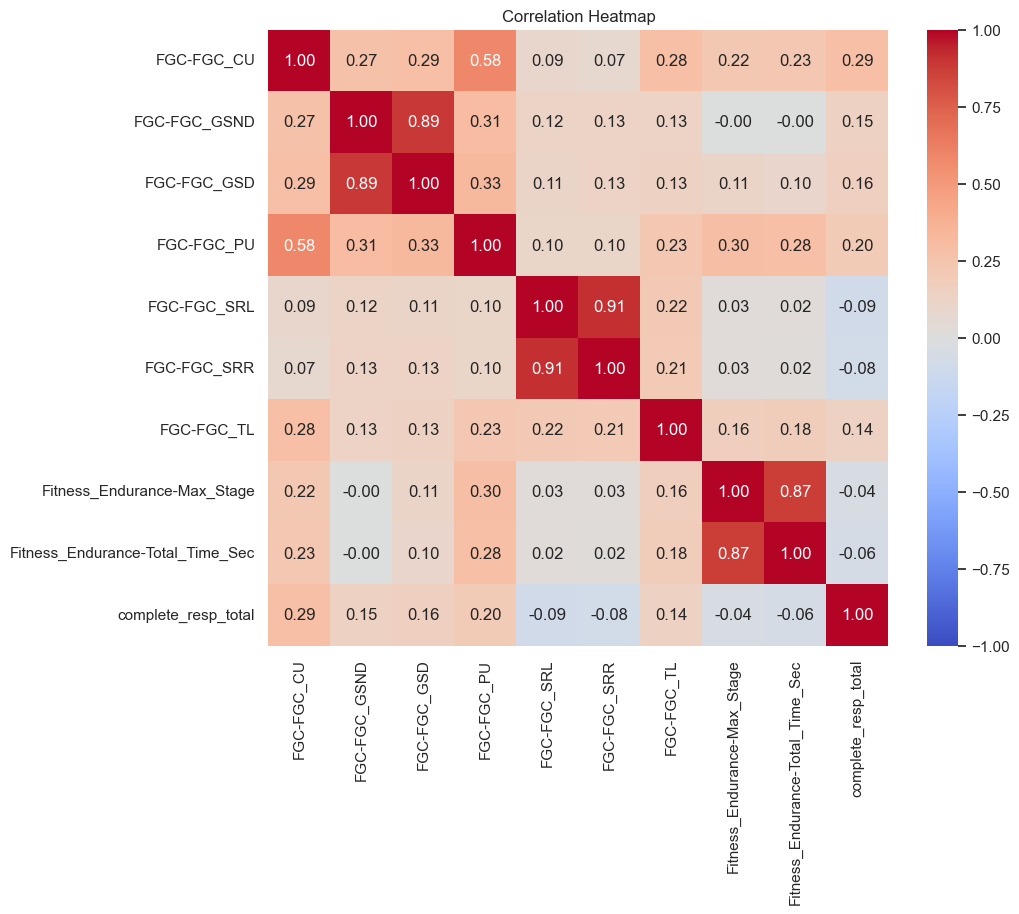

In [466]:
cols = [col for col in train.columns if col.startswith('FGC-')
        and 'Zone' not in col and 'Season' not in col]
cols.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>There are noticeable intercorrelations between the fitness measures (FGC-FGC_GSD (grip strength dominant) and FGC-FGC_GSND (grip strength non-dominant), FGC-FGC_SRL (sit & reach left) and FGC-FGC_SRR (sit & reach right)) and they are expected to be similar.
<li>The relationships with the target variable appear to be a counterintuitive: curl-ups and push-ups show moderate positive relationships with PIU severity, and trunk lift and grip strength show a weak positive correlation, suggesting that physical performance improves as PIU severity increases...
<li>Better performance in fitness tests does not necessarily indicate a higher level of daily physical activity. Besides, fitness measures might reflect past - we do not know the timing of the measurements.
<li>But the main thing to remember here is that physical performance also improves with age, so the positive correlation between physical performance and PIU severity is likely just driven by age.
<li>And here is another unknown: were the fitness tests conducted in a standardized way across all participants?
    </ul>
</div>

Let's see how the picture changes when we plot the same thing by age group, and add age to see if the measures still correlate with age.

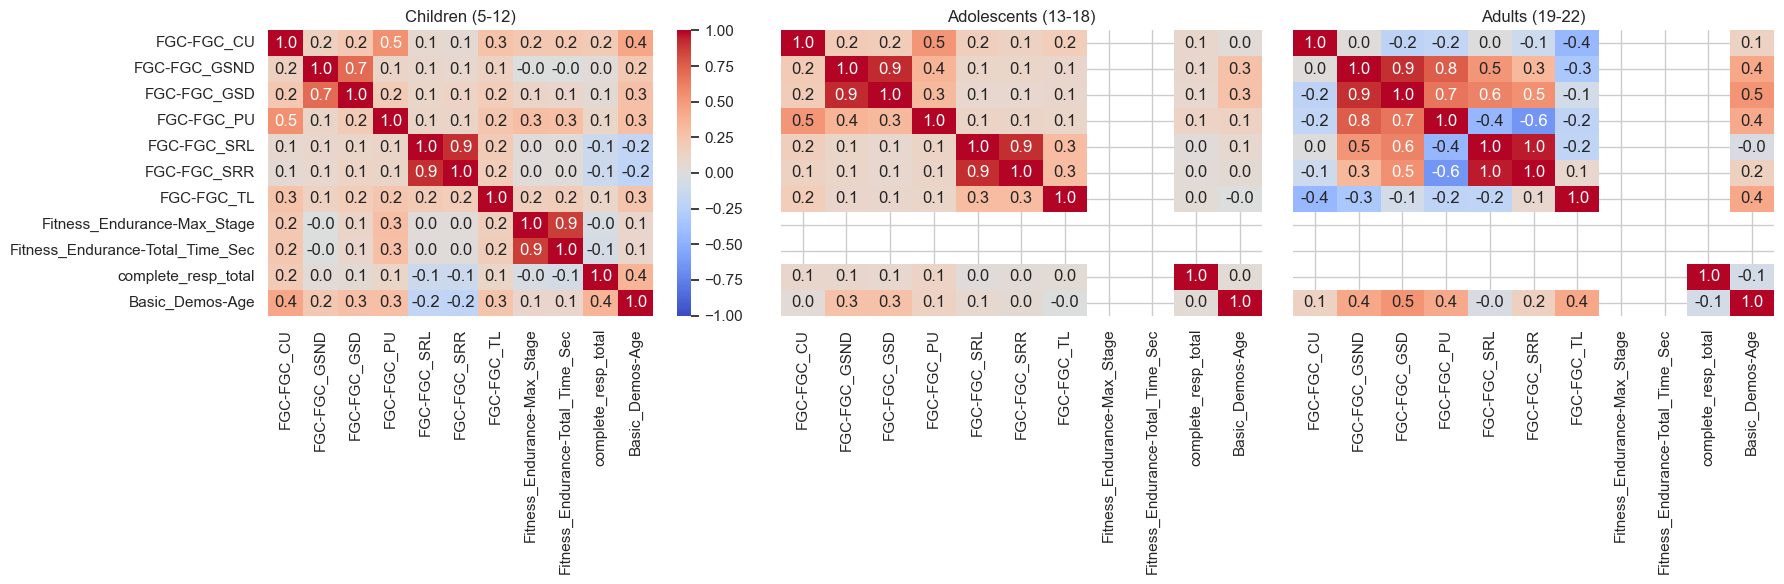

In [467]:
age_groups = train['Age Group'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, age_group in enumerate(age_groups):
    group_data = train[train['Age Group'] == age_group]
    corr_matrix = group_data[cols + ['complete_resp_total', 'Basic_Demos-Age']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f',
                vmin=-1, vmax=1, ax=axes[i], cbar=i == 0)
    axes[i].set_title(f'{age_group}')

plt.tight_layout()
plt.show()

In [468]:
train[
    (train['Age Group'] == 'Adults (19-22)') &
    (train['complete_resp_total'].notna()) &
    (train[cols].notna().any(axis=1))
][cols + ['complete_resp_total', 'Basic_Demos-Age']]

,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,Fitness_Endurance-Max_Stage,Fitness_Endurance-Total_Time_Sec,complete_resp_total,Basic_Demos-Age
1483,34.0,52.5,56.8,17.0,13.0,12.0,6.0,NaN,NaN,1.0,20


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>In each age group we see that age correlates well with most measures of physical performance (especially for kids and adults).
<li>The correlation between age and PIU severity persists in children aged 5-12 years, confounding the relationship between fitness and PIU.
<li>For adolescents, the correlations of the target variable with all measures of fitness are weak or null, and for adults who pass the fitness test, only 1 has data on PIU severity.
<li>In overall, fitness measures do not show noticable correlations with PIU severity, and it appears that age may be driving both increased fitness performance and higher PIU severity
    </ul>
</div>

# - Sleep Disturbance Scale

In [469]:
groups.get('Sleep Disturbance Scale', [])

['SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']

In [470]:
data = train[train['SDS-SDS_Total_Raw'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with SDS-SDS_Total_Raw data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with SDS-SDS_Total_Raw data: 5 - 22 years


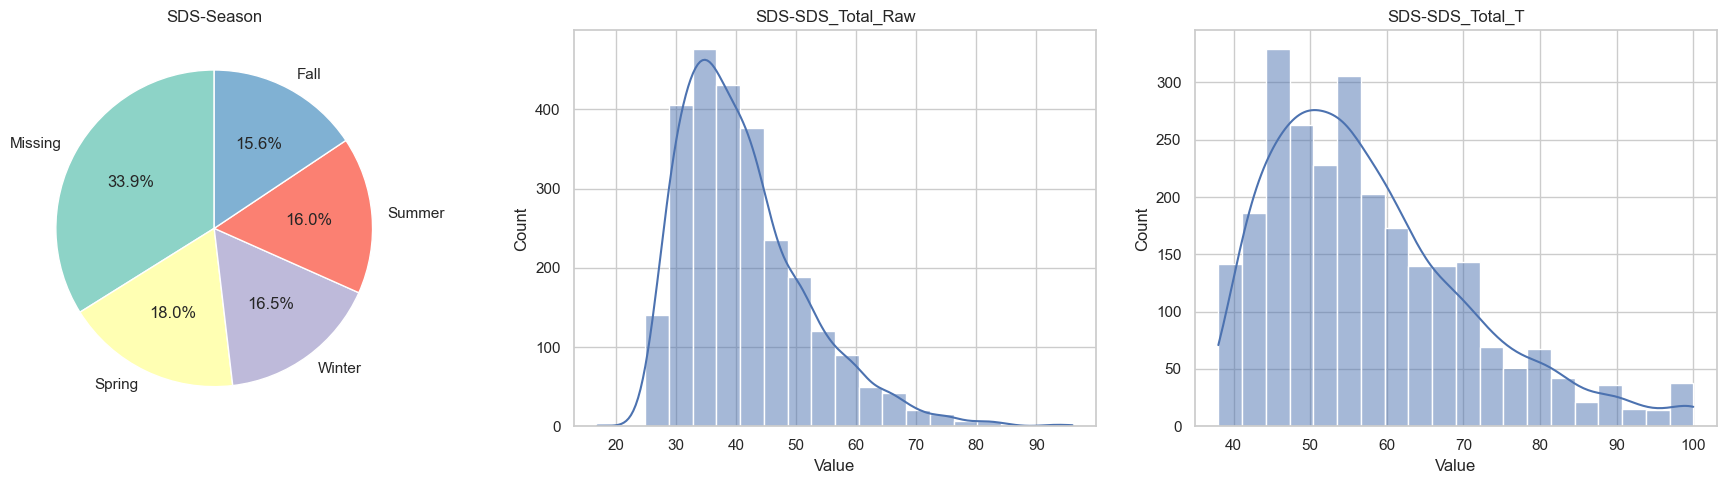

In [471]:
plt.figure(figsize=(18, 5))

# SDS-Season (Pie Chart)
plt.subplot(1, 3, 1)
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)
plt.pie(
    sds_season_counts,
    labels=sds_season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('SDS-Season')

# SDS-SDS_Total_Raw
plt.subplot(1, 3, 2)
sns.histplot(train['SDS-SDS_Total_Raw'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_Raw')
plt.xlabel('Value')

# SDS-SDS_Total_T
plt.subplot(1, 3, 3)
sns.histplot(train['SDS-SDS_Total_T'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_T')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [472]:
calculate_stats(train, ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'])

,count,mean,std,min,25%,50%,75%,max,missing
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.0,39.0,46.0,96.0,1351
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.0,55.0,64.0,100.0,1354


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>Both the raw and T-scores for sleep disturbance are moderately variable, with some extreme values indicating severe sleep disturbances in a subset of participants.
<li>Further Analysis (coming soon): to explore whether specific demographic factors (e.g., age, gender, season) are associated with higher sleep disturbance scores.
    </ul>
</div>

# <p style="background-color:#f3ebff; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #a281fc; border-radius:15px; padding:20px 20px;">Behavioral (subjective reported)</p>

# - Physical Activity Questionnaire

### Adolescents

In [473]:
groups.get('Physical Activity Questionnaire (Adolescents)', [])

['PAQ_A-Season', 'PAQ_A-PAQ_A_Total']

In [474]:
data = train[train['PAQ_A-PAQ_A_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Adolescents (with PAQ_A_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Adolescents (with PAQ_A_Total data): 13 - 18 years


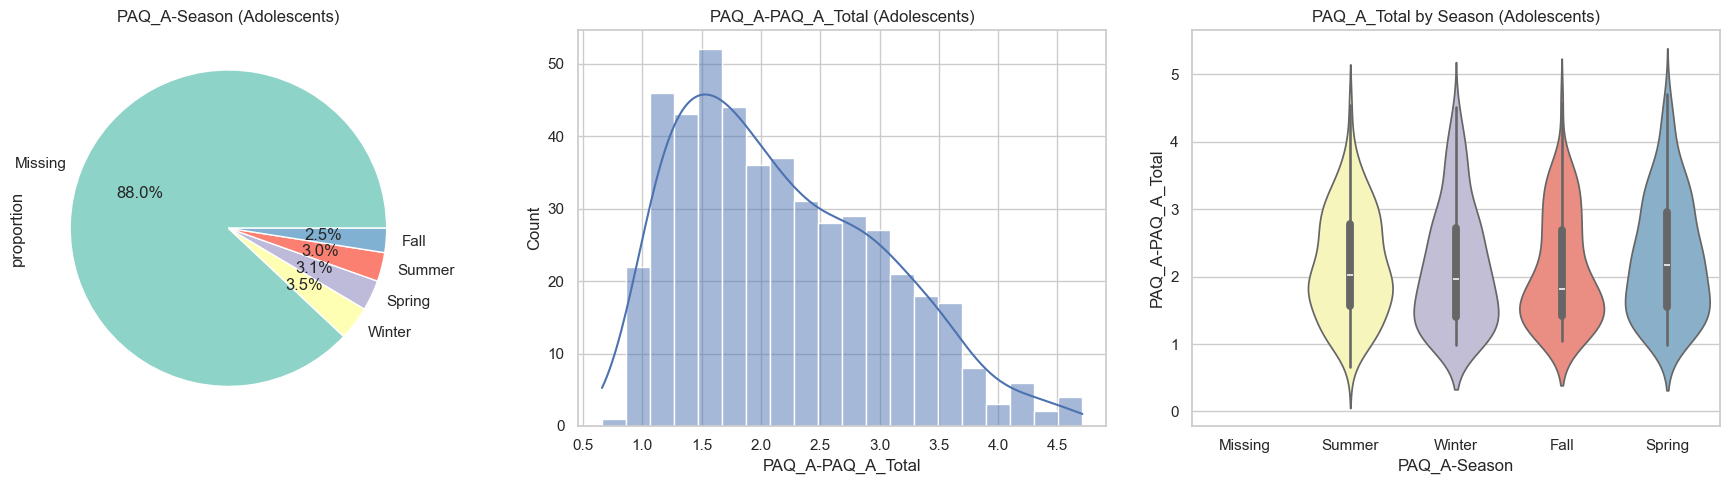

In [475]:
plt.figure(figsize=(18, 5))

# PAQ_A-Season
plt.subplot(1, 3, 1)
train['PAQ_A-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_A-Season (Adolescents)')

# PAQ_A-PAQ_A_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_A-PAQ_A_Total'], bins=20, kde=True)
plt.title('PAQ_A-PAQ_A_Total (Adolescents)')

# PAQ_A_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', data=train, palette="Set3")
plt.title('PAQ_A_Total by Season (Adolescents)')

plt.tight_layout()
plt.show()

In [476]:
calculate_stats(train, ['PAQ_A-PAQ_A_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_A-PAQ_A_Total,,,,,,,,,
PAQ_A-PAQ_A_Total,475.0,2.178853,0.849476,0.66,1.49,2.01,2.78,4.71,3485


### Children

In [477]:
groups.get('Physical Activity Questionnaire (Children)', [])

['PAQ_C-Season', 'PAQ_C-PAQ_C_Total']

In [478]:
data = train[train['PAQ_C-PAQ_C_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Children (with PAQ_C_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Children (with PAQ_C_Total data): 7 - 17 years


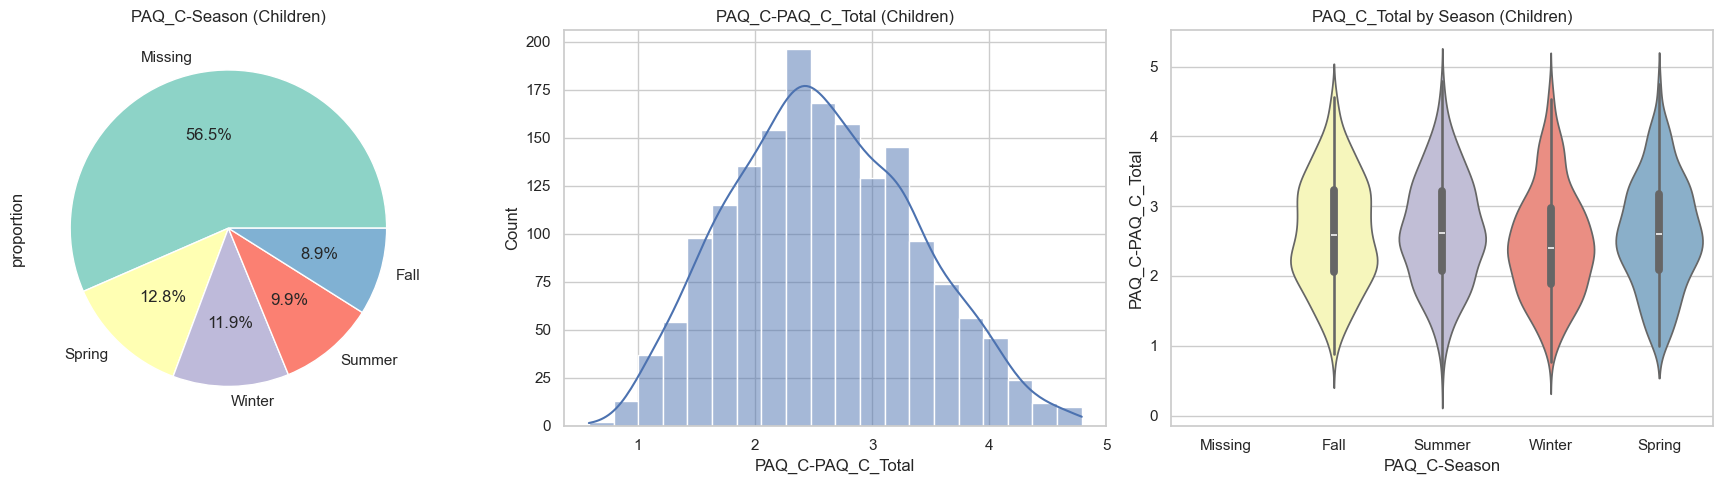

In [479]:
plt.figure(figsize=(18, 5))

# PAQ_C-Season
plt.subplot(1, 3, 1)
train['PAQ_C-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_C-Season (Children)')

# PAQ_C-PAQ_C_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_C-PAQ_C_Total'], bins=20, kde=True)
plt.title('PAQ_C-PAQ_C_Total (Children)')

# PAQ_C_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', data=train, palette="Set3")
plt.title('PAQ_C_Total by Season (Children)')

plt.tight_layout()
plt.show()

In [480]:
calculate_stats(train, ['PAQ_C-PAQ_C_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_C-PAQ_C_Total,,,,,,,,,
PAQ_C-PAQ_C_Total,1721.0,2.58955,0.783937,0.58,2.02,2.54,3.16,4.79,2239


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
    💡 Note:
    <ul style="list-style:circle">
<li>The division into adolescents and children seems to be incorrect (participants with data in the children columns (PAQ_C_Total) are 7 - 17 years old - overlapping with those with non-missing data in the adolescents columns - 13 - 18 years old).
<li>Physical activity levels are fairly stable over the seasons, with only minor variations, although are slightly lower in the fall and winter for adolescents and children, respectively.
<li>There are many missing values for these features
    </ul>
</div>

Check if any participants have data for both the children's PAQ (PAQ_C) and adolescents' PAQ (PAQ_A) columns

In [481]:
paq_columns = [col for col in train.columns if 'PAQ' in col]
train[(train['PAQ_A-PAQ_A_Total'].notnull()) &
      (train['PAQ_C-PAQ_C_Total'].notnull())][
    paq_columns + ['Basic_Demos-Age']
]

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
3331,Summer,2.27,Spring,2.32,13


May be it will make sense to combine PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total into a single column and take the average when both values are present.

In [482]:
# missing summary function
def missing_summary(df, name, top=50):
    n = len(df)
    miss_count = df.isnull().sum().sort_values(ascending=False)
    miss_pct = (miss_count / n * 100).round(3)
    summary = pd.DataFrame({'missing_count': miss_count, 'missing_pct': miss_pct})
    print(f"=== {name} shape: {df.shape} ===")
    print("Columns with missing (top):")
    display(summary[summary['missing_count']>0].head(top))
    # check object columns for literal strings 'nan','none' or empty
    obj_cols = df.select_dtypes(include=['object']).columns
    bogus = {}
    for c in obj_cols:
        s = df[c].astype(str).str.strip()
        cnt = ((s.isin(['nan','none',''])) & df[c].notna()).sum()  # string 'nan' but not real NaN
        if cnt>0:
            bogus[c]=int(cnt)
    if bogus:
        print("Columns containing literal strings like 'nan'/'none'/'':")
        print(bogus)
    # rows with any missing
    print("Rows with any missing:", df.isnull().any(axis=1).sum())
    display(df[df.isnull().any(axis=1)].head(10))

files_to_check = [
    ("train_cleaned.csv", "train"),
    ("test_cleaned.csv",  "test")
]

for filepath, name in files_to_check:
    path_obj = Path(filepath)
    
    if path_obj.exists():
        print(f"\n📂 Loading file: {filepath}")
        df = pd.read_csv(path_obj)
        missing_summary(df, name)
    else:
        print(f"⚠️ File not found: {filepath}")


📂 Loading file: train_cleaned.csv
=== train shape: (2736, 181) ===
Columns with missing (top):


,missing_count,missing_pct
PAQ_A-Season,2373,86.732
Fitness_Endurance-Season,1476,53.947
PAQ_C-Season,1296,47.368
BIA-Season,892,32.602
CGAS-Season,394,14.401
SDS-Season,209,7.639
Physical-Season,141,5.154
FGC-Season,89,3.253
PreInt_EduHx-Season,17,0.621
PCIAT-PCIAT_17,11,0.402


Rows with any missing: 2736


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,fall,5.0,0.0,winter,51.0,fall,2.630256,46.00,3.966511,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
1,000fd460,summer,9.0,0.0,NaN,65.0,fall,2.401126,48.00,3.871201,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
2,105258,summer,10.0,1.0,fall,71.0,fall,2.613644,56.50,4.351567,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
3,00115b9f,winter,9.0,0.0,fall,71.0,summer,2.727353,56.00,4.426044,...,1.386294,1.386294,10.655022,5.228189,2.787780,5.225747,5.198497,5.209486,5.192957,5.327876
4,001f3379,spring,13.0,1.0,winter,50.0,summer,2.959066,59.50,4.737951,...,1.386294,1.386294,12.887833,5.359830,2.155745,5.361292,5.361292,5.356586,5.356586,5.356586
5,0038ba98,fall,10.0,0.0,NaN,65.0,fall,2.813056,55.00,4.461300,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
6,00abe655,fall,11.0,0.0,summer,66.0,NaN,2.695911,55.00,4.354141,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
7,00ae59c9,fall,13.0,0.0,NaN,65.0,winter,2.894755,57.75,4.624973,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
8,00c0cd71,winter,7.0,0.0,summer,51.0,spring,3.270169,54.00,4.817051,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494
9,00d56d4b,spring,5.0,1.0,summer,80.0,spring,2.659175,44.00,3.903991,...,1.098612,1.386294,12.854795,5.118051,2.168090,5.111988,5.111988,5.111988,5.117994,5.147494



📂 Loading file: test_cleaned.csv
=== test shape: (20, 158) ===
Columns with missing (top):


,missing_count,missing_pct
PAQ_A-Season,19,95.0
Fitness_Endurance-Season,16,80.0
BIA-Season,12,60.0
PAQ_C-Season,11,55.0
SDS-Season,10,50.0
CGAS-Season,10,50.0
Physical-Season,6,30.0
FGC-Season,3,15.0
PreInt_EduHx-Season,2,10.0


Rows with any missing: 20


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,fall,5.0,0.0,winter,51.0,fall,1.577271,46.00,1.916923,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
1,000fd460,summer,9.0,0.0,NaN,65.0,fall,0.693147,48.00,0.693147,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
2,00105258,summer,10.0,1.0,fall,71.0,fall,1.528901,56.50,3.453157,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
3,00115b9f,winter,9.0,0.0,fall,71.0,summer,1.833662,56.00,3.627004,...,1.098612,0.693147,0.693147,3.065509,2.262866,3.091042,2.833213,2.944439,2.708050,3.583519
4,0016bb22,spring,18.0,1.0,summer,65.0,NaN,1.754995,55.00,3.459466,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
5,001f3379,spring,13.0,1.0,winter,50.0,summer,2.326727,59.50,4.222445,...,1.098612,0.693147,12.774416,3.864497,0.693147,3.891820,3.891820,3.871201,3.850148,3.737670
6,0038ba98,fall,10.0,0.0,NaN,65.0,fall,2.031455,55.00,3.703768,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
7,0068a485,fall,10.0,1.0,NaN,65.0,fall,1.573955,59.25,3.693867,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
8,0069fbed,summer,15.0,0.0,NaN,65.0,spring,1.754995,55.00,3.459466,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
9,0083e397,summer,19.0,1.0,summer,65.0,NaN,1.754995,55.00,3.459466,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147


In [483]:
# check outliers using z-score method
def detect_outliers_zscore(df, threshold=3.0):
    import numpy as np
    # chọn chỉ các cột số
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] == 0:
        return pd.DataFrame()  # không có cột số
    # tính z-score (dùng std population ddof=0)
    z = np.abs((num - num.mean()) / num.std(ddof=0))
    outlier_mask = (z > threshold).any(axis=1)
    return df.loc[outlier_mask]

# gọi hàm trên dataframe (vd. df hoặc train)
outliers_z = detect_outliers_zscore(df)
outliers_z.head()
# ...existing code...

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,fall,5.0,0.0,winter,51.0,fall,1.577271,46.0,1.916923,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
1,000fd460,summer,9.0,0.0,NaN,65.0,fall,0.693147,48.0,0.693147,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
2,00105258,summer,10.0,1.0,fall,71.0,fall,1.528901,56.5,3.453157,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147
3,00115b9f,winter,9.0,0.0,fall,71.0,summer,1.833662,56.0,3.627004,...,1.098612,0.693147,0.693147,3.065509,2.262866,3.091042,2.833213,2.944439,2.708050,3.583519
4,0016bb22,spring,18.0,1.0,summer,65.0,NaN,1.754995,55.0,3.459466,...,0.693147,0.693147,12.737336,0.693147,0.745384,0.693147,0.693147,0.693147,0.693147,0.693147


In [484]:
# ...existing code...
# Kiểm tra an toàn các cột có thể chứa thông tin giới tính và in giá trị duy nhất
candidate_cols = ['gender', 'Gender', 'sex', 'Sex', 'Basic_Demos-Sex', 'Basic_Demos-Gender']
found = [c for c in candidate_cols if c in df.columns]

if not found:
    print("Không tìm thấy cột giới tính (gender/sex). Một số cột hiện có (tối đa 50):")
    print(list(df.columns[:50]))
else:
    for c in found:
        print(f"Giá trị duy nhất trong cột '{c}':")
        print(df[c].unique())
# ...existing code...

Giá trị duy nhất trong cột 'Basic_Demos-Sex':
[0. 1.]


In [485]:
df.duplicated().sum()
df['id'].duplicated().sum()


np.int64(0)

In [486]:
def consistency_checks(df):
    results = {}

    # Rule 1: Age range
    results['age_invalid'] = df[(df['Basic_Demos-Age'] < 5) | (df['Basic_Demos-Age'] > 25)]
    
    # Rule 2: Sex must be 0 or 1
    results['sex_invalid'] = df[~df['Basic_Demos-Sex'].isin([0, 1])]
    
    # Rule 3: Example skip logic
    if set(['PlayGame','G1','G2','G3']).issubset(df.columns):
        results['skip_logic'] = df[
            (df['PlayGame'] == 0) &
            (df[['G1','G2','G3']].notna().any(axis=1))
        ]
    
    # Rule 4: Start < End
    if set(['start_time','end_time']).issubset(df.columns):
        results['time'] = df[df['start_time'] > df['end_time']]
    
    return results


# ---- RUN AND PRINT ----
results = consistency_checks(df)

for key, value in results.items():
    print(f"\n🔍 {key.upper()} — số lỗi: {len(value)}")
    if len(value) > 0:
        display(value.head())



🔍 AGE_INVALID — số lỗi: 0

🔍 SEX_INVALID — số lỗi: 0
